# A Deep Learning Approach to Music Genre Classification Using Audio Spectrograms (GTZAN)

- **Machine Learning Algorithms**
- **José Miguel Sousa**

This notebook presents an end-to-end, reproducible Machine Learning workflow for **music genre classification** using **deep learning applied to audio signals**.  
The proposed solution leverages **time-frequency representations of audio** (Mel-spectrograms) derived from the **GTZAN dataset** and employs a **convolutional neural network (MobileNetV2)** to perform genre classification.

The solution leverages **time-series features** (the GTZAN “3-second” features CSV) to build per-track sequences and trains multiple neural architectures (baseline and tuned).  
It includes: data understanding, feature engineering, model selection, hyperparameter tuning, robust evaluation, interpretability, and a lightweight deployment proof-of-concept.

## 1. Problem Definition

### 1.1 Goal

The goal of this work is to develop an intelligent system capable of automatically classifying music tracks into predefined musical genres based on their audio content.

The problem addressed is the **music genre classification** task, explored under two complementary approaches:

1. A **baseline model** based on traditional Machine Learning, where **time-series audio features** are extracted from short temporal windows and stored in a structured CSV format.

2. A **deep learning approach**, where raw audio signals are transformed into **time–frequency representations (Mel-spectrograms)** derived from short audio segments. 

This problem is motivated by real-world applications such as music recommendation systems, audio content organization, and automatic metadata generation for large music libraries.

### 1.2 Success Criteria

The success of the proposed models is evaluated according to the following criteria:

- Both the baseline and deep learning models must correctly predict the musical genre of previously unseen audio tracks.
- The task is formulated as a **supervised multi-class classification** problem, where each track belongs to exactly one genre.
- Model performance is primarily assessed using the **Macro F1-score**, ensuring balanced evaluation across all genres.
- Secondary evaluation metrics include overall accuracy, precision, recall, and confusion matrix analysis.
- The deep learning model is expected to outperform the baseline model in terms of generalization performance, demonstrating the benefits of learned feature representations.
- All models must demonstrate good generalization capability on a held-out test dataset that was not used during training or validation.


In [ ]:
import kagglehub
import shutil
from pathlib import Path

# execute once

TARGET_DIR = Path("datasets/")
TARGET_DIR.mkdir(parents=True, exist_ok=True)

cache_path = Path(
    kagglehub.dataset_download(
         "andradaolteanu/gtzan-dataset-music-genre-classification"
    )
)

print("Kagglehub cache location:", cache_path)
if not (TARGET_DIR / "features_3_seconds.csv").exists():
    shutil.copytree(cache_path, TARGET_DIR, dirs_exist_ok=True)
    print("Dataset copied to:", TARGET_DIR)
else:
    print("Dataset already exists at:", TARGET_DIR)


c:\Users\jose.m.sousa\.conda\envs\assessment_ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Kagglehub cache location: C:\Users\jose.m.sousa\.cache\kagglehub\datasets\andradaolteanu\gtzan-dataset-music-genre-classification\versions\1


KeyboardInterrupt: 

## 2. Data Understanding and Preparation

This phase focuses on understanding the dataset structure, identifying potential data quality issues, 
and preparing the data for training sequential deep learning models.

### 2.1 Data Source

The dataset used in this work is the **GTZAN Music Genre Dataset**, retrieved programmatically using the 
`kagglehub` library and stored locally under the `datasets/gtzan/` directory.

The dataset contains audio tracks distributed across ten musical genres, along with precomputed audio 
features extracted over fixed temporal windows.

In [3]:
import pandas as pd
from pathlib import Path

df = pd.read_csv(Path("datasets/Data/features_3_sec.csv"))
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


### 2.2 Dataset Structure

Each music track in the dataset is divided into consecutive **3-second audio segments**.  
For each segment, a set of numerical audio features is computed.

Key characteristics:
- Multiple rows correspond to the same track
- Each track is represented by approximately 10 temporal segments
- Each row contains:
  - A track identifier (`filename`)
  - A genre label
  - A set of numeric audio descriptors

This structure enables modeling the data as a **time series**.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

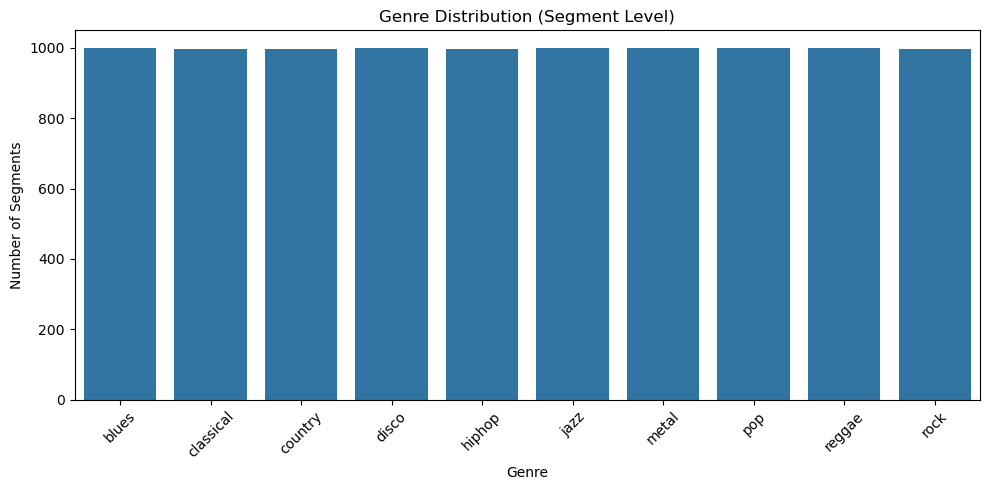

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

genre_counts = df["label"].value_counts().sort_index()

plt.figure(figsize=(10,5))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title("Genre Distribution (Segment Level)")
plt.xlabel("Genre")
plt.ylabel("Number of Segments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This figure presents the distribution of 3-second audio segments across the ten musical genres in the GTZAN dataset. Each genre is represented by approximately the same number of segments, indicating a balanced dataset at the segment level. This balance is important to prevent bias during model training and ensures that no genre disproportionately influences the learning process. Although the final classification is performed at the track level, this plot confirms that the underlying segmented data are evenly distributed across classes.

### 2.3 Data Quality Checks

Before modeling, the dataset is inspected for:
- Missing values
- Duplicate rows
- Label consistency

In [5]:
print("Missing values per column:")
print(df.isna().sum())

print("\nNumber of duplicate rows:", df.duplicated().sum())

Missing values per column:
filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean      

In addition to numerical checks, the distribution of the number of segments per track is analyzed to identify potential inconsistencies.

In this GTZAN dataset, ``filename`` is not the name of the song, but a segment-level filename:
- blues.00000.000.wav
- blues.00000.001.wav
- blues.00000.002.wav
- ...

Each 3-second segment has a unique filename, so filename ≠ track.

For that reason, we need to extract the base track name and derive a ``track_id`` column, as a track identifier.


In [6]:
df["track_id"] = df["filename"].apply(
    lambda x: ".".join(x.split(".")[:2])
)

df[["filename", "track_id"]]

,filename,track_id
0,blues.00000.0.wav,blues.00000
1,blues.00000.1.wav,blues.00000
2,blues.00000.2.wav,blues.00000
3,blues.00000.3.wav,blues.00000
4,blues.00000.4.wav,blues.00000
...,...,...
9985,rock.00099.5.wav,rock.00099
9986,rock.00099.6.wav,rock.00099
9987,rock.00099.7.wav,rock.00099
9988,rock.00099.8.wav,rock.00099


Now the distribution of the number of segments per track is analyzed to identify potential inconsistencies.

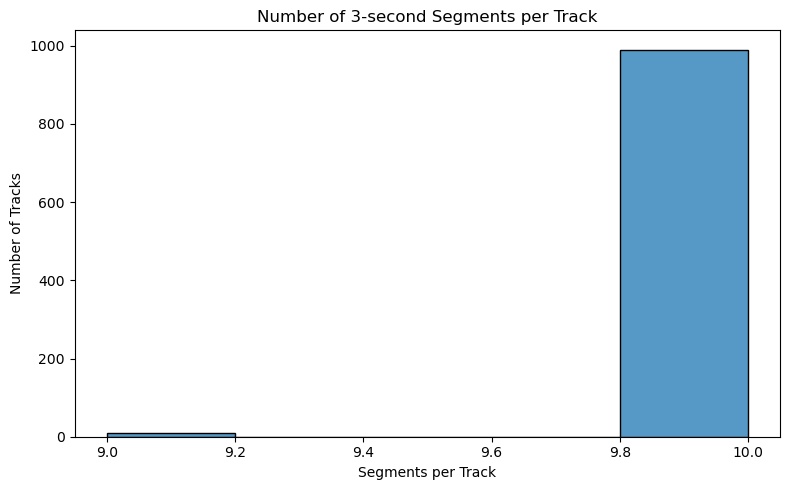

In [7]:
import matplotlib.pyplot as plt, seaborn as sns

segment_counts = df.groupby("track_id").size()

plt.figure(figsize=(8,5))
sns.histplot(segment_counts, bins=5)
plt.title("Number of 3-second Segments per Track")
plt.xlabel("Segments per Track")
plt.ylabel("Number of Tracks")
plt.tight_layout()
plt.show()

This histogram illustrates the number of 3-second audio segments associated with each music track in the GTZAN dataset. The vast majority of tracks contain exactly ten segments, corresponding to the expected segmentation of 30-second audio excerpts. A small number of tracks contain only nine segments, likely due to minor preprocessing inconsistencies or truncated recordings. This analysis supports the decision to construct fixed-length time-series representations by selecting a maximum of ten segments per track, ensuring consistent input dimensionality for sequential neural network models.

### 2.4 Data Leakage Risk

Because each track is split into multiple temporal segments, a naive random split of rows would result 
in segments from the same track appearing in both training and test sets.

This would lead to **data leakage** and overly optimistic performance estimates.

To prevent this, all dataset splits are performed at the **track level**, ensuring that all segments 
of a given track belong to the same subset.


In [8]:
#check how many segments exist
ID_COL = "track_id"

segment_counts = df.groupby(ID_COL).size()
segment_counts.describe()

count    1000.000000
mean        9.990000
std         0.099549
min         9.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
dtype: float64

In [10]:
LABEL_COL = "label"

NON_FEATURE_COLS = ["filename", ID_COL, LABEL_COL]

if "length" in df.columns:
    NON_FEATURE_COLS.append("length")

FEATURE_COLS = [
    c for c in df.columns
    if c not in NON_FEATURE_COLS and pd.api.types.is_numeric_dtype(df[c])
]

print("Number of feature columns:", len(FEATURE_COLS))
FEATURE_COLS[:5]


Number of feature columns: 57


['chroma_stft_mean',
 'chroma_stft_var',
 'rms_mean',
 'rms_var',
 'spectral_centroid_mean']

So now if we re-check the segments, we can confirm that the grouping is correct and each group relates to a song.

In [11]:
segment_counts = df.groupby(ID_COL).size()
segment_counts.describe()

count    1000.000000
mean        9.990000
std         0.099549
min         9.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
dtype: float64

### 2.5 Time-Series Sequence Construction

For each music track, the corresponding 3-second audio segments are grouped together to form a fixed-length time series representation. Since each original audio excerpt has a duration of approximately 30 seconds, it is expected to be composed of around ten consecutive 3-second segments.

In this step, segments belonging to the same track are identified using a reconstructed track-level identifier and ordered temporally according to their filenames. Tracks with fewer than the expected number of segments are discarded to ensure consistent input dimensionality across all samples.

As a result, each track is represented as:
- A sequence of `T = 10` time steps, corresponding to consecutive 3-second windows
- Each time step containing `F = 57` numerical audio features

This transformation converts the original tabular dataset into a three-dimensional tensor of shape:


In [12]:
import numpy as np

EXPECTED_SEGMENTS = 10

X = [] #time series
y = [] #genre label
track_ids = []

for track, group in df.groupby("track_id"):
    if len(group) < EXPECTED_SEGMENTS:
        continue

    #temporal order
    group = group.sort_values("filename")
    group = group.iloc[:EXPECTED_SEGMENTS]

    X.append(group[FEATURE_COLS].values)
    y.append(group[LABEL_COL].iloc[0])
    track_ids.append(track)

X = np.array(X, dtype=np.float32)
y = np.array(y)
track_ids = np.array(track_ids)

print("Input shape (tracks, time steps, features):", X.shape)
print("Number of classes:", len(np.unique(y)))


Input shape (tracks, time steps, features): (990, 10, 57)
Number of classes: 10


### 2.6 Label Encoding

The target variable (music genre) is categorical and must be transformed into a numerical representation 
before training the models. Label encoding is used to map each genre to a unique integer value.

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

label_encoder.classes_

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

### 2.7 Train / Validation / Test Split

The dataset is split into training, validation, and test subsets using stratified sampling at the 
track level. This ensures that:
- No temporal segments from the same track appear in multiple subsets
- Genre distribution is preserved across splits

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded,
    test_size=0.30,
    stratify=y_encoded,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

X_train.shape, X_val.shape, X_test.shape


((693, 10, 57), (148, 10, 57), (149, 10, 57))

### 2.8 Feature Scaling

To improve training stability and convergence speed, all audio features are standardized using 
a `StandardScaler`. The scaler is fitted exclusively on the training data to prevent information leakage.


Prior to normalization, the distributions of selected features are inspected to assess scale differences and skewness.

For visualization purposes, a small representative subset of numerical audio features is selected, as plotting all features would be impractical. This subset is used solely for exploratory analysis and does not affect model training.

In [15]:
sample_features = FEATURE_COLS[:6]

sample_features

['chroma_stft_mean',
 'chroma_stft_var',
 'rms_mean',
 'rms_var',
 'spectral_centroid_mean',
 'spectral_centroid_var']

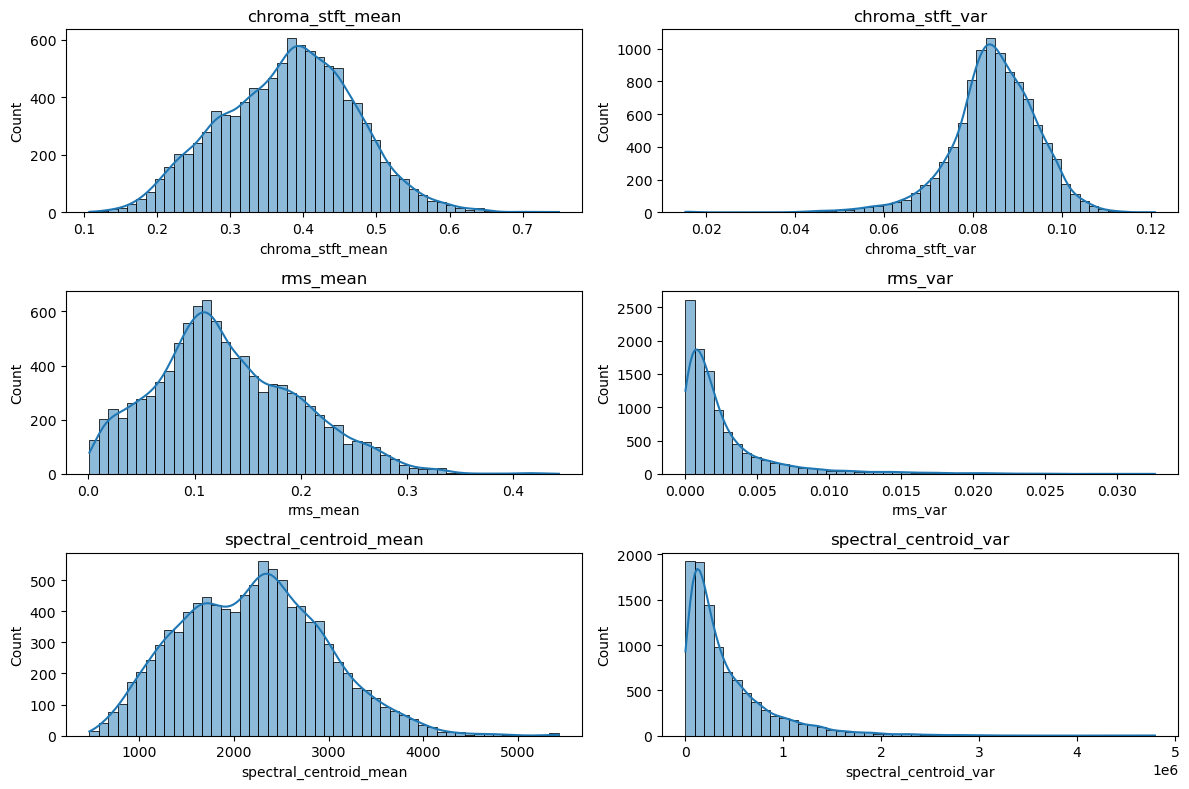

In [16]:
plt.figure(figsize=(12,8))
for i, feat in enumerate(sample_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[feat], bins=50, kde=True)
    plt.title(feat)

plt.tight_layout()
plt.show()


These observations confirm that the raw audio features are neither centered nor scaled consistently and that several features differ by multiple orders of magnitude. Without normalization, features with larger numerical ranges would dominate the learning process, potentially degrading model convergence and performance.
For these reasons, feature standardization using a ``StandardScaler`` is applied in the subsequent step, ensuring zero mean and unit variance across all training time steps while preserving the temporal structure required for sequential modeling.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_flat = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_flat)

def scale_sequences(X):
    return scaler.transform(
        X.reshape(-1, X.shape[-1])
    ).reshape(X.shape) # tracks x time, features instead tracks,time,features

X_train = scale_sequences(X_train)
X_val   = scale_sequences(X_val)
X_test  = scale_sequences(X_test)

X_train


array([[[-6.17186189e-01,  9.27032411e-01,  1.11366069e+00, ...,
          2.21016335e+00,  1.36903182e-01,  6.88956857e-01],
        [-1.62220597e-01,  8.41985881e-01,  1.66459894e+00, ...,
         -1.06011644e-01,  2.99422204e-01, -1.07595652e-01],
        [ 2.89826274e-01,  1.31251478e+00,  1.77051997e+00, ...,
          6.24225795e-01,  7.51786053e-01,  2.96619654e-01],
        ...,
        [-5.38216591e-01,  1.12638295e+00,  1.66721582e+00, ...,
          1.21669590e+00,  1.11910748e+00,  2.42142797e+00],
        [-8.36150944e-01,  1.27087563e-01,  2.01883936e+00, ...,
          1.43663198e-01,  8.35120022e-01,  7.92705894e-01],
        [-5.90736151e-01,  6.09053671e-01,  2.12145853e+00, ...,
          2.32584620e+00, -1.38833976e+00, -1.41777232e-01]],

       [[ 4.99208927e-01,  2.61748254e-01, -4.65297371e-01, ...,
         -5.62395930e-01,  2.10745782e-02, -5.09653389e-01],
        [ 5.23563564e-01, -3.22951004e-02, -3.61592054e-01, ...,
         -3.86690199e-01,  4.72498685e

Because the sequential models expect inputs of shape (_tracks_,_time steps_, _features_), the normalizaition is applied across all training time steps by temporarily reshaping the data to a 2D matrix (_tracks_ x _time steps_, _features_). After scaling, the data are reshaped back to the original 3D structure, preserving the temporal ordering required by LSTM/CNN models.

As a result, each feature is approximately centered around zero with unit variance in the training set, improving convergence speed an training stability. The same fitted scaler is then applied to the validation and test sets.

In [18]:
train_flat = X_train.reshape(-1, X_train.shape[-1])
print("Train mean (first 5 features):", train_flat.mean(axis=0)[:5])
print("Train std  (first 5 features):", train_flat.std(axis=0)[:5])


Train mean (first 5 features): [ 9.0135899e-08 -5.2525643e-08 -4.7477293e-09  9.9814130e-09
 -5.7764041e-08]
Train std  (first 5 features): [1.0000001  1.0000002  0.99999976 0.9999998  1.0000006 ]


Each feature is centered at zero and scaled to unit variance across the training set.

### 2.9 Summary of Data Preparation

At the end of the data preparation phase, the original segment-level GTZAN dataset has been transformed into a clean and well-structured track-level representation suitable for sequential deep learning models.

Each music track is represented as a fixed-length time series composed of ten consecutive 3-second segments, preserving temporal order while ensuring consistent input dimensionality. A reconstructed track-level identifier was used to correctly group segments belonging to the same original audio excerpt, preventing data leakage during dataset splitting.

All preprocessing steps were carefully designed to ensure methodological rigor. Dataset splits were performed at the track level with stratification by genre, guaranteeing that no segments from the same track appear in multiple subsets and that class distributions are preserved across training, validation, and test sets.

Finally, all numerical audio features were standardized using statistics computed exclusively from the training data. This normalization step accounts for heterogeneous feature scales and improves optimization stability while maintaining the three-dimensional time-series structure required by the sequential models.

As a result, the final dataset is balanced, leakage-free, and fully standardized, providing a reliable foundation for the model selection and training phases that follow.

## Phase 3 - Model Selection and Justification

This phase focuses on the **selection and justification of candidate models** for music genre classification.

Two main model families are explored:

1. **Classical machine learning baselines**, operating on aggregated track-level features.
2. **Sequential deep learning models**, operating directly on track-level time-series representations.

Model selection is performed using the **validation Macro F1-score**, which ensures balanced performance across all musical genres.

### Evaluation Strategy

The primary evaluation metric used throughout this phase is the **Macro F1-score**, to ensure balanced performance across genres, penalizing models that perform well on some classes but poorly on others.

The dataset is divided into:
- Training set (70%)
- Validation set (15%)
- Test set (15%)

The **validation set** is used exclusively for model selection.  
The **test set** is used only once, for the final evaluation of the selected model.


In [19]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

def evaluate_model(y_true, y_pred, label_encoder=None, prefix=""):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    precm = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recm = recall_score(y_true, y_pred, average="macro", zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    print(f"{prefix}Accuracy:        {acc:.4f}")
    print(f"{prefix}Macro F1-score:  {f1m:.4f}")
    print(f"{prefix}Macro Precision: {precm:.4f}")
    print(f"{prefix}Macro Recall:    {recm:.4f}\n")

    if label_encoder is not None:
        print(classification_report(
            y_true, y_pred,
            target_names=label_encoder.classes_,
            zero_division=0
        ))
    else:
        print(classification_report(y_true, y_pred, zero_division=0))

    return {
        "accuracy": acc,
        "macro_f1": f1m,
        "macro_precision": precm,
        "macro_recall": recm,
        "confusion_matrix": cm
    }

### 3.1 Baseline Models

As a reference point, classical machine learning models are trained using **aggregated track-level features**.

Each track-level time series is summarized using:
- Mean of each feature across time
- Standard deviation of each feature across time

This produces a fixed-length representation per track and allows the use of traditional classifiers.


In [20]:
def aggregate_track_features(X):
    mean_features = X.mean(axis=1)
    std_features = X.std(axis=1)
    return np.concatenate([mean_features, std_features], axis=1)

X_train_agg = aggregate_track_features(X_train)
X_val_agg   = aggregate_track_features(X_val)
X_test_agg  = aggregate_track_features(X_test)

X_train_agg.shape, X_val_agg.shape, X_test_agg.shape

((693, 114), (148, 114), (149, 114))

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

baseline_models = {
    "Logistic Regression": LogisticRegression(max_iter=3000, n_jobs=-1),
    "SVM (RBF)": SVC(kernel="rbf", C=5.0, gamma="scale"),
    "Random Forest": RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
}

baseline_results = {}

for name, model in baseline_models.items():
    model.fit(X_train_agg, y_train)
    val_pred = model.predict(X_val_agg)

    print("=" * 70)
    print(f"Baseline Model: {name}")
    baseline_results[name] = evaluate_model(
        y_val, val_pred,
        label_encoder=label_encoder,
        prefix="[VAL] "
    )


Baseline Model: Logistic Regression
[VAL] Accuracy:        0.7973
[VAL] Macro F1-score:  0.7990
[VAL] Macro Precision: 0.8057
[VAL] Macro Recall:    0.7971

              precision    recall  f1-score   support

       blues       0.86      0.80      0.83        15
   classical       1.00      0.86      0.92        14
     country       0.93      0.87      0.90        15
       disco       0.53      0.60      0.56        15
      hiphop       0.71      0.71      0.71        14
        jazz       0.79      1.00      0.88        15
       metal       0.93      0.93      0.93        15
         pop       0.86      0.80      0.83        15
      reggae       0.73      0.73      0.73        15
        rock       0.71      0.67      0.69        15

    accuracy                           0.80       148
   macro avg       0.81      0.80      0.80       148
weighted avg       0.81      0.80      0.80       148

Baseline Model: SVM (RBF)
[VAL] Accuracy:        0.8378
[VAL] Macro F1-score:  0.838

Hyperparameters were set to reasonable default values and were not extensively tuned in order to preserve a fair comparison with sequential models.

### 3.1.2 Baseline Model Selection

Among the evaluated classical machine learning models, the Support Vector Machine with RBF kernel achieved the highest validation performance, with a Macro F1-score of approximately **0.84**.

This model is selected as the **reference baseline** for subsequent comparisons with sequential deep learning architectures. No further tuning is performed at this stage in order to preserve a fair and consistent comparison.


In [22]:
best_baseline_name = "SVM (RBF)"
best_baseline_model = baseline_models[best_baseline_name]

baseline_results[best_baseline_name]


{'accuracy': 0.8378378378378378,
 'macro_f1': 0.8379815844765789,
 'macro_precision': 0.8495168067226893,
 'macro_recall': 0.8380952380952381,
 'confusion_matrix': array([[14,  0,  0,  0,  0,  0,  0,  0,  1,  0],
        [ 0, 14,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 14,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0, 12,  2,  0,  0,  0,  0,  1],
        [ 1,  0,  0,  0, 10,  0,  0,  0,  3,  0],
        [ 1,  0,  0,  0,  0, 14,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  0,  0, 14,  0,  0,  0],
        [ 0,  0,  1,  0,  1,  0,  0, 12,  1,  0],
        [ 0,  1,  0,  1,  1,  0,  0,  0, 12,  0],
        [ 0,  0,  0,  6,  0,  0,  1,  0,  0,  8]])}

This result is consistent with the ability of RBF SVMs to model non-linear class boundaries on compact, standardized feature representations.

## 3.2 Sequential Deep Learning Models

While the baseline models operate on aggregated statistics and ignore temporal ordering, musical audio is inherently sequential.

Sequential neural networks are therefore evaluated to determine whether modeling the temporal evolution of audio features across consecutive segments provides additional discriminative power beyond global statistics.


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)
np.random.seed(42)

NUM_CLASSES = len(np.unique(y_train))
INPUT_SHAPE = X_train.shape[1:]  # (time_steps, features)


In [24]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        mode="max",
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=5,
        factor=0.5,
        min_lr=1e-6
    )
]

Early stopping is applied by monitoring validation accuracy, ensuring that training is halted when classification performance no longer improves. Learning rate reduction is simultaneously employed to stabilize optimization and mitigate overfitting.

In [25]:
def build_lstm_model():
    inp = keras.Input(shape=INPUT_SHAPE)
    x = layers.LSTM(64, return_sequences=False)(inp)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inp, out, name="LSTM_small")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


lstm_model = build_lstm_model()
lstm_model.summary()

Model: "LSTM_small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 57)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        31,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,042 (140.79 KB)

 Trainable params: 36,042 (140.79 KB)

 Non-trainable params: 0 (0.00 B)

The proposed compact LSTM processes each track as a sequence of 10 time steps with 57 features per step. A single LSTM layer with 64 units summarizes the sequence into a fixed-length embedding, followed by a small fully connected layer. Dropout is applied to reduce overfitting. This reduced-capacity design (≈36k parameters) is intended to improve generalization given the limited dataset size.

In [26]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

val_pred_lstm = np.argmax(lstm_model.predict(X_val), axis=1)

lstm_val_metrics = evaluate_model(
    y_val,
    val_pred_lstm,
    label_encoder=label_encoder,
    prefix="[VAL LSTM] "
)

lstm_val_metrics


Epoch 1/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2006 - loss: 2.1927 - val_accuracy: 0.4392 - val_loss: 1.9417 - learning_rate: 0.0010
Epoch 2/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3434 - loss: 1.8810 - val_accuracy: 0.4662 - val_loss: 1.6822 - learning_rate: 0.0010
Epoch 3/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4098 - loss: 1.7208 - val_accuracy: 0.5203 - val_loss: 1.4857 - learning_rate: 0.0010
Epoch 4/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5108 - loss: 1.5034 - val_accuracy: 0.6014 - val_loss: 1.3268 - learning_rate: 0.0010
Epoch 5/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5137 - loss: 1.3937 - val_accuracy: 0.6081 - val_loss: 1.1938 - learning_rate: 0.0010
Epoch 6/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5512 - loss: 1.2821 - val_accuracy: 0.6554 - val_loss: 1.0932 - learning_rate: 0.0010
Epoch 7/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6089 - loss: 1.1654 - val_accuracy:

{'accuracy': 0.8243243243243243,
 'macro_f1': 0.8280041645305337,
 'macro_precision': 0.8421912246680048,
 'macro_recall': 0.8233333333333333,
 'confusion_matrix': array([[12,  0,  0,  0,  1,  0,  0,  0,  2,  0],
        [ 0, 12,  0,  0,  0,  2,  0,  0,  0,  0],
        [ 0,  0, 15,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 11,  2,  0,  1,  1,  0,  0],
        [ 1,  0,  0,  0,  9,  0,  0,  0,  4,  0],
        [ 0,  0,  0,  0,  0, 15,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1,  0, 14,  0,  0,  0],
        [ 0,  0,  0,  3,  0,  0,  0, 12,  0,  0],
        [ 0,  0,  0,  1,  2,  0,  0,  1, 11,  0],
        [ 0,  0,  0,  4,  0,  0,  0,  0,  0, 11]])}

On the validation set, the LSTM achieves an accuracy of 0.82 and a Macro F1-score of 0.83. While this indicates strong performance, it remains below the classical reference baseline (RBF SVM, Macro F1 ≈ 0.838). Confusion matrix inspection shows that errors are concentrated among stylistically similar genres (notably rock, disco, and reggae), suggesting that the segment-level statistical feature representation may limit the benefits of explicit temporal modeling over only 10 time steps.

### 3.3 Temporal Convolutional Model (CNN1D)

While recurrent neural networks model long-range temporal dependencies, convolutional architectures focus on learning **local temporal patterns** and are often more robust on short sequences.

A 1D Convolutional Neural Network (CNN1D) is therefore evaluated as an alternative sequential architecture to assess whether localized temporal dynamics improve classification performance.

In [27]:
def build_cnn1d_model():
    inp = keras.Input(shape=INPUT_SHAPE)

    x = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inp, out, name="CNN1D")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

cnn1d_model = build_cnn1d_model()
cnn1d_model.summary()

Model: "CNN1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 57)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 128)        │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,122 (352.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 512 (2.00 KB)

In [29]:
history_cnn = cnn1d_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

val_pred_cnn = np.argmax(cnn1d_model.predict(X_val), axis=1)

cnn_val_metrics = evaluate_model(
    y_val,
    val_pred_cnn,
    label_encoder=label_encoder,
    prefix="[VAL CNN1D] "
)

cnn_val_metrics


Epoch 1/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5916 - loss: 1.2017 - val_accuracy: 0.5608 - val_loss: 1.4623 - learning_rate: 2.5000e-04
Epoch 2/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6638 - loss: 1.0564 - val_accuracy: 0.6419 - val_loss: 1.3259 - learning_rate: 2.5000e-04
Epoch 3/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7403 - loss: 0.8942 - val_accuracy: 0.6959 - val_loss: 1.1962 - learning_rate: 2.5000e-04
Epoch 4/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7662 - loss: 0.8215 - val_accuracy: 0.7297 - val_loss: 1.0845 - learning_rate: 2.5000e-04
Epoch 5/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7662 - loss: 0.7497 - val_accuracy: 0.7432 - val_loss: 0.9797 - learning_rate: 2.5000e-04
Epoch 6/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8124 - loss: 0.6774 - val_accuracy: 0.7838 - val_loss: 0.9166 - learning_rate: 1.2500e-04
Epoch 7/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8312 - loss

{'accuracy': 0.5608108108108109,
 'macro_f1': 0.5008232871458251,
 'macro_precision': 0.5123276466096832,
 'macro_recall': 0.5633333333333334,
 'confusion_matrix': array([[ 9,  0,  0,  0,  0,  1,  2,  0,  3,  0],
        [ 0, 14,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 7,  2,  3,  0,  0,  1,  1,  1,  0,  0],
        [ 0,  1,  1,  2,  3,  1,  2,  4,  1,  0],
        [ 0,  0,  0,  0,  7,  1,  1,  4,  1,  0],
        [ 2,  4,  0,  0,  0,  9,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  0,  0, 14,  0,  0,  0],
        [ 0,  0,  0,  1,  0,  0,  0, 14,  0,  0],
        [ 1,  0,  0,  0,  1,  0,  0,  2, 11,  0],
        [ 0,  2,  0,  3,  0,  1,  6,  3,  0,  0]])}

The 1D Convolutional Neural Network (CNN1D) achieves moderate validation performance, with an accuracy of 0.561 and a Macro F1-score of 0.501. These results indicate limited generalization capability and noticeable class-wise imbalance, as reflected by the gap between overall accuracy and macro-averaged metrics.

Analysis of the confusion matrix reveals that while certain genres are classified reliably, several classes exhibit substantial confusion, particularly among acoustically similar genres. Some classes show consistently high true positive rates, whereas others suffer from widespread misclassification, suggesting overlapping feature distributions within the dataset.

Compared to classical baselines, the CNN1D model does not reach competitive performance, remaining well below the strongest traditional approaches such as the RBF SVM. This outcome suggests that, for the adopted feature representation, explicit temporal modeling via 1D convolutions does not provide sufficient discriminative advantage.

Overall, these results reinforce the observation that feature representation has a greater impact on classification performance than model complexity in this setting. Without richer temporal or spectral information, the CNN1D architecture is unable to fully exploit its modeling capacity

### 3.4 Model Selection Outcome

The comparative evaluation shows that classical machine learning models operating on aggregated track-level statistics achieve the strongest overall performance on the GTZAN 3-second feature representation. While sequential deep learning architectures, particularly the CNN1D model, demonstrate competitive results, none surpass the best classical baseline.

Among all evaluated candidates, the **Support Vector Machine with RBF kernel** achieves the highest validation performance and is therefore selected as the final model for subsequent evaluation.

These findings suggest that, for precomputed segment-level statistical audio features, global descriptors already capture most of the discriminative information required for music genre classification, limiting the additional benefit of explicit temporal modeling over short sequences.


## Phase 4 - Final Evaluation and Representation-Level Comparison

This phase consolidates the findings of the previous modeling stages and extends the analysis by comparing different data representations. The phase is divided into two complementary parts:

1. Phase 4A focuses on final model selection and evaluation using the previously extracted time-series audio features.

2. Phase 4B revisits the raw audio data and explores spectrogram-based representations to assess whether learning directly from time-frequency images enables improved performance with convolutional neural networks.


### Phase 4A - Final Evaluation and Model Finalization

This phase builds directly on the results of Phase 3 by (i) evaluating the selected candidate models on the held-out test set, (ii) confirming final model selection based on validation Macro F1-score, and (iii) retraining the selected model using the combined training and validation data prior to final testing.

The objective of Phase 4A is to finalize a defensible and reproducible reference model using time-series audio features before transitioning to spectrogram-based convolutional models in Phase 4B.


In [30]:
best_baseline_model

,C,5.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [31]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

def predict_labels(model, X, batch_size=32):
    """
    Returns (y_pred, y_prob_or_None).
    Supports both Keras models and sklearn models (e.g., SVM).
    """
    try:
        prob = model.predict(X, batch_size=batch_size, verbose=0)
        if hasattr(prob, "ndim") and prob.ndim == 2:
            return np.argmax(prob, axis=1), prob
        return prob, None
    except TypeError:
        y_pred = model.predict(X)
        prob = model.predict_proba(X) if hasattr(model, "predict_proba") else None
        return y_pred, prob

def plot_history(history, title="Training Curves"):
    hist = history.history
    epochs = range(1, len(hist.get("loss", [])) + 1)

    plt.figure()
    if "loss" in hist:
        plt.plot(list(epochs), hist["loss"], label="train_loss")
    if "val_loss" in hist:
        plt.plot(list(epochs), hist["val_loss"], label="val_loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if "accuracy" in hist or "val_accuracy" in hist:
        plt.figure()
        if "accuracy" in hist:
            plt.plot(list(epochs), hist["accuracy"], label="train_acc")
        if "val_accuracy" in hist:
            plt.plot(list(epochs), hist["val_accuracy"], label="val_acc")
        plt.title(f"{title} (Accuracy)")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()

def plot_confusion(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

def eval_and_report(model, X, y, set_name="TEST", class_names=None, prefix=""):
    """
    Uses your evaluate_model() to print metrics and returns (metrics_dict, confusion_matrix).
    """
    y_pred, _ = predict_labels(model, X)
    metrics = evaluate_model(
        y, y_pred,
        label_encoder=label_encoder,
        prefix=f"{prefix}[{set_name}] "
    )
    cm = confusion_matrix(y, y_pred)

    if class_names is None:
        class_names = label_encoder.classes_

    plot_confusion(cm, class_names, title=f"{set_name} Confusion Matrix")
    return metrics, cm


#### 4A.1 Test-Set Reporting (No Model Selection)

For completeness, the main candidate models are evaluated on the held-out test set. These results are reported for comparison only; **model selection remains based on validation Macro F1-score** established in Phase 3.


[TEST (SVM - trained on TRAIN)] Accuracy:        0.7852
[TEST (SVM - trained on TRAIN)] Macro F1-score:  0.7884
[TEST (SVM - trained on TRAIN)] Macro Precision: 0.8022
[TEST (SVM - trained on TRAIN)] Macro Recall:    0.7857

              precision    recall  f1-score   support

       blues       0.67      0.67      0.67        15
   classical       0.83      1.00      0.91        15
     country       0.86      0.86      0.86        14
       disco       0.79      0.73      0.76        15
      hiphop       0.86      0.80      0.83        15
        jazz       1.00      0.93      0.97        15
       metal       0.83      0.67      0.74        15
         pop       1.00      0.80      0.89        15
      reggae       0.55      0.80      0.65        15
        rock       0.64      0.60      0.62        15

    accuracy                           0.79       149
   macro avg       0.80      0.79      0.79       149
weighted avg       0.80      0.79      0.79       149



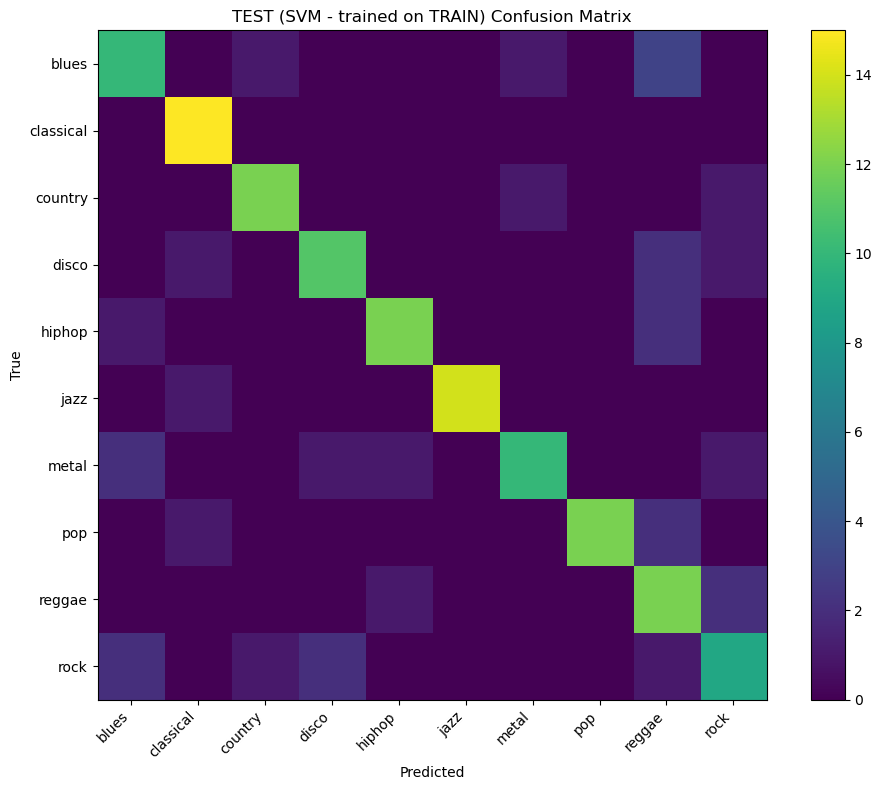

In [32]:
svm_test_metrics, svm_test_cm = eval_and_report(
    best_baseline_model, X_test_agg, y_test,
    set_name="TEST (SVM - trained on TRAIN)",
    class_names=label_encoder.classes_
)


[TEST (CNN1D - trained on TRAIN)] Accuracy:        0.4698
[TEST (CNN1D - trained on TRAIN)] Macro F1-score:  0.3959
[TEST (CNN1D - trained on TRAIN)] Macro Precision: 0.4327
[TEST (CNN1D - trained on TRAIN)] Macro Recall:    0.4676

              precision    recall  f1-score   support

       blues       0.44      0.47      0.45        15
   classical       0.44      1.00      0.61        15
     country       1.00      0.14      0.25        14
       disco       0.00      0.00      0.00        15
      hiphop       0.36      0.33      0.34        15
        jazz       0.64      0.47      0.54        15
       metal       0.50      0.80      0.62        15
         pop       0.43      0.80      0.56        15
      reggae       0.53      0.67      0.59        15
        rock       0.00      0.00      0.00        15

    accuracy                           0.47       149
   macro avg       0.43      0.47      0.40       149
weighted avg       0.43      0.47      0.40       149



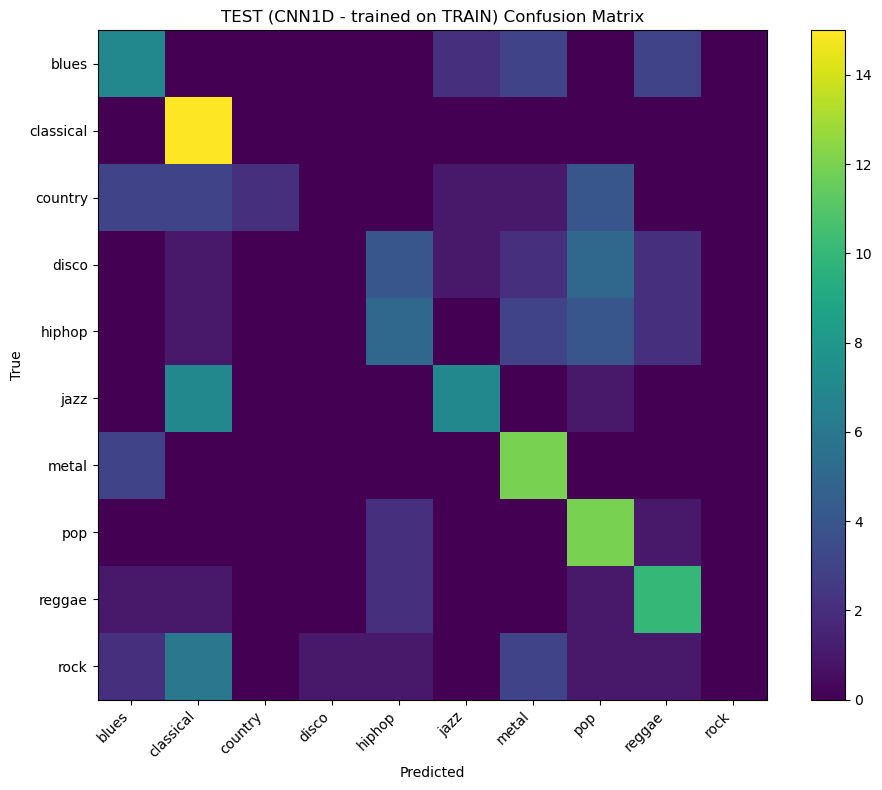

In [33]:
cnn_test_metrics, cnn_test_cm = eval_and_report(
    cnn1d_model, X_test, y_test,
    set_name="TEST (CNN1D - trained on TRAIN)",
    class_names=label_encoder.classes_
)


The candidate models selected in Phase 3 were evaluated on the held-out test set to provide an unbiased estimate of their generalization performance. Importantly, these results are reported for analysis only; final model selection remains strictly based on validation Macro F1-score.

The SVM with RBF kernel achieves a test accuracy of **0.79** and a Macro F1-score of **0.79**. Performance is particularly strong for genres such as *classical*, *jazz*, *country*, and *pop*, while increased confusion is observed among stylistically overlapping genres, notably *reggae*, *rock*, and *blues*. This pattern is consistent with known ambiguities in the GTZAN dataset.

The CNN1D model, trained under the same conditions, achieves a lower test accuracy (**0.47**) and Macro F1-score (**0.40**).

Inspection of the confusion matrices provides deeper insight into the comparative behavior of the CNN1D and SVM models. Both approaches achieve near-perfect recognition of the classical genre, confirming that it exhibits highly distinctive acoustic characteristics that are well captured by the extracted features.

For jazz, performance remains strong (particularly for the SVM) although the CNN1D shows noticeable confusion with acoustically related genres, indicating less stable class separation.

Across both models, systematic confusion persists among stylistically similar genres such as rock, reggae, and blues, reflecting shared rhythmic and timbral properties that are difficult to disentangle using segment-level statistical descriptors. Additional confusion patterns, including disco–pop and blues–metal, are especially pronounced in the CNN1D model, suggesting limitations in its ability to learn robust temporal discriminators from short sequences.

In contrast, the SVM exhibits more stable and consistent predictions across classes, with fewer extreme misclassifications and a cleaner diagonal structure. This behavior indicates more balanced recall and lower inter-class variance, supporting the conclusion that, for the adopted feature representation, margin-based classifiers generalize more reliably than deep temporal models in the low-data, short-segment regime.

#### 4A.1.1 Hyperparameter Finetuning (CNN1D)

To strengthen the deep learning baseline, a limited hyperparameter finetuning procedure is performed for the CNN1D architecture. This step is intentionally constrained to a small, controlled search space to improve performance while maintaining reproducibility and avoiding overfitting to the validation set.

Tuning is conducted **exclusively on the validation split**, and the held-out test set remains fully isolated until the final evaluation stage. The **Macro F1-score** is used as the primary selection metric, ensuring balanced performance across genres.

The following hyperparameters are explored:
- number of convolutional filters,
- kernel size,
- dropout rate,
- dense layer width,
- learning rate.

The best configuration is selected based on validation Macro F1-score and is then retrained on the combined train+validation set prior to producing the final test report.


In [ ]:
import numpy as np, os, random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score
from itertools import product

os.environ["PYTHONHASHSEED"] = "42"

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def build_cnn1d_tunable(
    filters=128,
    kernel_size=3,
    dropout=0.4,
    dense_units=128,
    lr=1e-3
):
    inp = keras.Input(shape=INPUT_SHAPE)

    x = layers.Conv1D(filters, kernel_size=kernel_size, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(filters, kernel_size=kernel_size, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout)(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inp, out, name="CNN1D_TUNED")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuning_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",   
        patience=10,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=5,
        factor=0.5,
        min_lr=1e-6
    )
]

grid = {
    "filters":     [64, 128],
    "kernel_size": [3, 5],
    "dropout":     [0.3, 0.4, 0.5],
    "dense_units": [64, 128],
    "lr":          [1e-3, 5e-4]
}

candidate_configs = [
    {"filters": 128, "kernel_size": 3, "dropout": 0.4, "dense_units": 128, "lr": 1e-3},
    {"filters": 128, "kernel_size": 5, "dropout": 0.4, "dense_units": 128, "lr": 1e-3},
    {"filters": 64,  "kernel_size": 3, "dropout": 0.4, "dense_units": 128, "lr": 1e-3},
    {"filters": 128, "kernel_size": 3, "dropout": 0.5, "dense_units": 128, "lr": 1e-3},
    {"filters": 128, "kernel_size": 3, "dropout": 0.3, "dense_units": 128, "lr": 1e-3},
    {"filters": 128, "kernel_size": 3, "dropout": 0.4, "dense_units": 64,  "lr": 1e-3},
    {"filters": 128, "kernel_size": 3, "dropout": 0.4, "dense_units": 128, "lr": 5e-4},
    {"filters": 64,  "kernel_size": 5, "dropout": 0.4, "dense_units": 128, "lr": 5e-4},
]

results = []

for i, cfg in enumerate(candidate_configs, start=1):
    print("=" * 80)
    print(f"Tuning run {i}/{len(candidate_configs)} - config: {cfg}")

    keras.backend.clear_session()
    set_seeds(42 + i) # different seed per run for more control
    model = build_cnn1d_tunable(**cfg)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=80,
        batch_size=32,
        callbacks=tuning_callbacks,
        verbose=0
    )

    val_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)
    val_f1 = f1_score(y_val, val_pred, average="macro")

    best_val_acc = float(np.max(history.history.get("val_accuracy", [np.nan])))

    results.append({
        "config": cfg,
        "val_macro_f1": float(val_f1),
        "best_val_accuracy": best_val_acc,
        "epochs_ran": len(history.history.get("loss", [])),
        "val_pred_counts": np.bincount(val_pred, minlength=NUM_CLASSES).tolist()
    })

results_sorted = sorted(results, key=lambda d: d["val_macro_f1"], reverse=True)

print("\nTop configurations by validation Macro F1:")
for r in results_sorted[:5]:
    print(f"MacroF1={r['val_macro_f1']:.4f} | best_val_acc={r['best_val_accuracy']:.4f} | epochs={r['epochs_ran']} | cfg={r['config']}")

best_cfg = results_sorted[0]["config"]
best_cfg


Tuning run 1/8 - config: {'filters': 128, 'kernel_size': 3, 'dropout': 0.4, 'dense_units': 128, 'lr': 0.001}

Tuning run 2/8 - config: {'filters': 128, 'kernel_size': 5, 'dropout': 0.4, 'dense_units': 128, 'lr': 0.001}
Tuning run 3/8 - config: {'filters': 64, 'kernel_size': 3, 'dropout': 0.4, 'dense_units': 128, 'lr': 0.001}
Tuning run 4/8 - config: {'filters': 128, 'kernel_size': 3, 'dropout': 0.5, 'dense_units': 128, 'lr': 0.001}
Tuning run 5/8 - config: {'filters': 128, 'kernel_size': 3, 'dropout': 0.3, 'dense_units': 128, 'lr': 0.001}
Tuning run 6/8 - config: {'filters': 128, 'kernel_size': 3, 'dropout': 0.4, 'dense_units': 64, 'lr': 0.001}
Tuning run 7/8 - config: {'filters': 128, 'kernel_size': 3, 'dropout': 0.4, 'dense_units': 128, 'lr': 0.0005}
Tuning run 8/8 - config: {'filters': 64, 'kernel_size': 5, 'dropout': 0.4, 'dense_units': 128, 'lr': 0.0005}

Top configurations by validation Macro F1:
MacroF1=0.8598 | best_val_acc=0.8986 | epochs=32 | cfg={'filters': 128, 'kernel_size

{'filters': 128,
 'kernel_size': 5,
 'dropout': 0.4,
 'dense_units': 128,
 'lr': 0.001}

A constrained hyperparameter search was conducted for the CNN1D model using the validation set exclusively. Candidate models were ranked according to **validation Macro F1-score**, in order to prioritize balanced class-wise performance rather than overall accuracy alone.

The best-performing configuration achieved a validation Macro F1-score of **0.8598**, with a peak validation accuracy of **0.8986**. This configuration employed:
- **128 convolutional filters**
- **kernel size = 5**
- **dropout = 0.4**
- **128 dense units**
- **Adam optimizer with learning rate = 1e-3**

Compared to configurations using a smaller kernel size (3), the larger temporal receptive field provided by a kernel size of 5 appears to better capture discriminative patterns across the 3-second input segments, resulting in improved class-wise balance.

Based on these results, the selected configuration is retrained using the combined training and validation sets prior to final evaluation on the test set.

Other tested configurations underperformed in terms of validation Macro F1-score, highlighting the sensitivity of CNN1D performance to architectural choices and regularization strength. For clarity and reproducibility, only the top-performing configurations are retained for subsequent comparison and test evaluation.

In [35]:
from tensorflow import keras
import numpy as np
import tensorflow as tf

tf.random.set_seed(42)
np.random.seed(42)

# train + val
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

best_cfg = {
    "filters": 128,
    "kernel_size": 5,
    "dropout": 0.4,
    "dense_units": 128,
    "lr": 0.001
}

keras.backend.clear_session()
cnn1d_tuned_final = build_cnn1d_tunable(**best_cfg)

history_cnn1d_tuned_final = cnn1d_tuned_final.fit(
    X_trainval, y_trainval,
    epochs=32,
    batch_size=32,
    verbose=1
)

test_pred = np.argmax(cnn1d_tuned_final.predict(X_test, verbose=0), axis=1)
cnn1d_tuned_test_metrics = evaluate_model(
    y_test, test_pred,
    label_encoder=label_encoder,
    prefix="[TEST CNN1D TUNED (train+val)] "
)

cnn1d_tuned_test_metrics

Epoch 1/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4257 - loss: 1.6530
Epoch 2/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6778 - loss: 0.9421
Epoch 3/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7765 - loss: 0.7048
Epoch 4/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8312 - loss: 0.5203
Epoch 5/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8906 - loss: 0.3820
Epoch 6/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9156 - loss: 0.2884
Epoch 7/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9322 - loss: 0.2383
Epoch 8/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9572 - loss: 0.1711
Epoch 9/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9762 - loss: 0.1265
Epoch 10/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9715 - loss: 0.1196
Epoch 11/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9834 - loss: 0.0814
Epoch 12/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9834 - lo

{'accuracy': 0.7718120805369127,
 'macro_f1': 0.7679781105990784,
 'macro_precision': 0.7759407993966817,
 'macro_recall': 0.7704761904761905,
 'confusion_matrix': array([[ 9,  0,  0,  0,  0,  2,  1,  0,  3,  0],
        [ 0, 15,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  8,  3,  0,  1,  0,  1,  0,  1],
        [ 0,  0,  0,  9,  2,  0,  0,  1,  2,  1],
        [ 0,  0,  0,  0, 13,  0,  0,  0,  2,  0],
        [ 1,  1,  0,  0,  0, 12,  0,  1,  0,  0],
        [ 2,  0,  0,  0,  1,  0, 12,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 14,  1,  0],
        [ 0,  0,  1,  0,  0,  0,  0,  0, 12,  2],
        [ 1,  1,  1,  1,  0,  0,  0,  0,  0, 11]])}

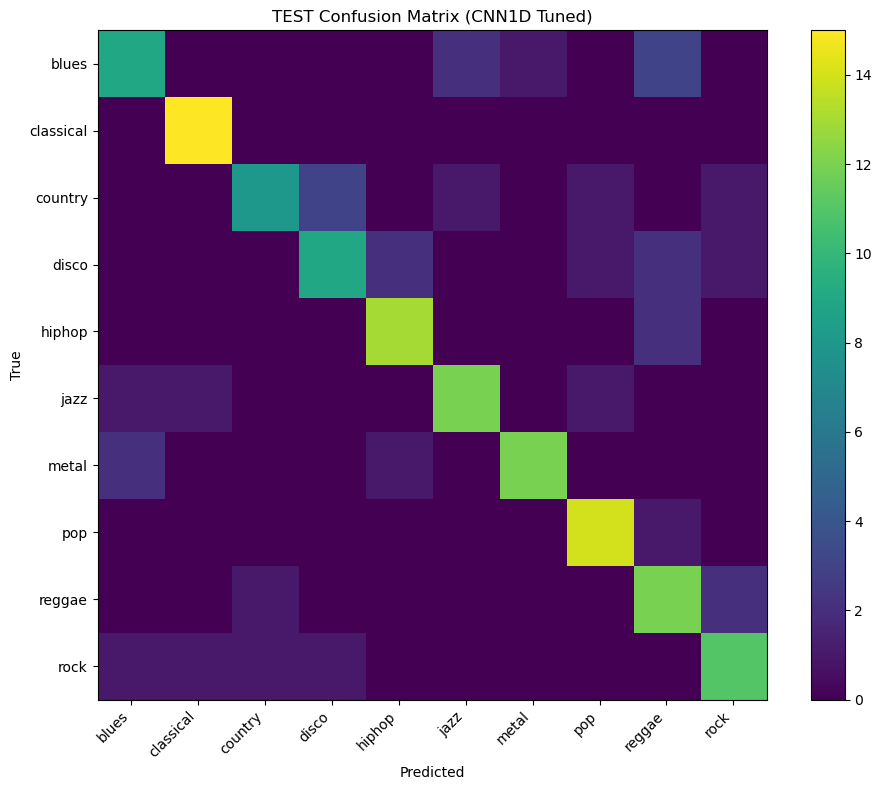

In [36]:

cm_tuned = confusion_matrix(y_test, test_pred)
plot_confusion(cm_tuned, label_encoder.classes_, title="TEST Confusion Matrix (CNN1D Tuned)")

### 4A.2 Final Evaluation and Discussion

The tuned CNN1D model, selected based on validation Macro F1-score, was retrained on the combined train and validation data and evaluated once on the held-out test set. The resulting performance is as follows:

- **Accuracy:** 0.7718  
- **Macro F1-score:** 0.7680  

For comparison, the classical SVM baseline achieved a slightly higher test Macro F1-score of approximately **0.79**, remaining the strongest overall performer on this feature representation.

#### Error Analysis

Inspection of the test-set confusion matrix indicates that the tuned CNN1D model achieves strong performance on structurally and acoustically distinctive genres such as *classical*, *metal*, *hiphop*, and *pop*, with high concentrations along the diagonal. Nevertheless, residual confusion persists among stylistically related genres, most notably *blues*, *disco*, *country*, and *rock*. These confusions largely reflect overlapping rhythmic and timbral characteristics that are difficult to resolve using compact statistical descriptors.

Importantly, the observed error patterns are consistent with those seen in the untuned CNN1D and classical baseline models, suggesting that the remaining misclassifications stem primarily from limitations in the underlying feature representation rather than from suboptimal model configuration.

#### Discussion

Despite substantial gains in validation performance achieved through hyperparameter tuning, the CNN1D model does not surpass the classical SVM baseline on the test set. This performance gap highlights the limited advantage of convolutional temporal modeling when applied to short, highly summarized 3-second feature sequences, where global descriptors already capture much of the discriminative information.

Overall, these results indicate that, for the GTZAN 3-second statistical feature representation, **margin-based classifiers combined with global features provide superior generalization** compared to deep sequential models. Consequently, the SVM with RBF kernel is retained as the final model for time-series feature-based classification.

These findings motivate the transition to Phase 4B, in which raw audio signals are transformed into spectrogram images, enabling convolutional neural networks to operate directly on richer time–frequency representations.


## Phase 4B - Spectrogram-based CNN (Audio to Image)

In this sub-phase, the genre classification task is reframed as an **image classification problem** by using **spectrogram images**.

### Objectives
1. Build a reproducible spectrogram pipeline that guarantees **consistent class-to-index mapping** across splits.
2. Train a **CNN2D from scratch** on spectrograms and evaluate performance on the validation split.
3. Apply standard training strategies (mini-batches, early stopping, learning-rate scheduling) and overfitting countermeasures (dropout, batch normalization).

### Key risk: large white border in images
Many spectrogram PNGs include a strong white margin around the time–frequency content. This can dominate the input signal and hurt generalization.  
We mitigate this by resizing slightly larger and then applying a deterministic **center-crop**.


### 4B.1 Dataset Loading (Stratified Train/Val/Test Split)

To enable a rigorous evaluation protocol comparable to Phase 4C, the spectrogram dataset is split explicitly
into **train / validation / test** partitions using **stratified sampling** at the image level.

This approach guarantees:
- a stable and reproducible **class-to-index mapping** (derived from folder names),
- balanced class distributions across all splits,
- a fully isolated test set reserved for final reporting.


In [37]:
import numpy as np
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = Path("datasets/Data/images_original")

class_names = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
NUM_CLASSES = len(class_names)
class_to_idx = {c: i for i, c in enumerate(class_names)}

print("Class names:", class_names)
print("NUM_CLASSES:", NUM_CLASSES)

all_paths = []
all_labels = []

for cls in class_names:
    for fp in sorted((DATA_DIR / cls).glob("*.png")):
        all_paths.append(str(fp))
        all_labels.append(class_to_idx[cls])

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

print("Total images:", len(all_paths))


Class names: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
NUM_CLASSES: 10
Total images: 999


In [38]:
X_train, X_temp, y_train, y_temp = train_test_split(
    all_paths,
    all_labels,
    test_size=0.30,
    random_state=SEED,
    stratify=all_labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=SEED,
    stratify=y_temp
)

print("Train:", len(X_train))
print("Val:  ", len(X_val))
print("Test: ", len(X_test))


Train: 699
Val:   150
Test:  150


In [39]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 32
IMG_SIZE = (256, 256)  
CROP_SIZE = (224, 224) 

AUTOTUNE = tf.data.AUTOTUNE

def decode_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.resize_with_crop_or_pad(img, CROP_SIZE[0], CROP_SIZE[1])
    return img, label

def make_ds(paths, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, shuffle=True)
val_ds   = make_ds(X_val,   y_val,   shuffle=False)
test_ds  = make_ds(X_test,  y_test,  shuffle=False)


### 4B.2 Labels and Visual Inspection

Before training, we verify:
- labels span all classes (0..9),
- both splits are balanced (or close),
- after preprocessing (rescale + center-crop), the spectrogram content is visible and borders are reduced.


In [40]:
def print_split_dist(name, y):
    u, c = np.unique(y, return_counts=True)
    print(f"{name} label dist:", dict(zip(u, c)))

print_split_dist("Train", y_train)
print_split_dist("Val  ", y_val)
print_split_dist("Test ", y_test)

Train label dist: {np.int64(0): np.int64(70), np.int64(1): np.int64(70), np.int64(2): np.int64(70), np.int64(3): np.int64(70), np.int64(4): np.int64(70), np.int64(5): np.int64(69), np.int64(6): np.int64(70), np.int64(7): np.int64(70), np.int64(8): np.int64(70), np.int64(9): np.int64(70)}
Val   label dist: {np.int64(0): np.int64(15), np.int64(1): np.int64(15), np.int64(2): np.int64(15), np.int64(3): np.int64(15), np.int64(4): np.int64(15), np.int64(5): np.int64(15), np.int64(6): np.int64(15), np.int64(7): np.int64(15), np.int64(8): np.int64(15), np.int64(9): np.int64(15)}
Test  label dist: {np.int64(0): np.int64(15), np.int64(1): np.int64(15), np.int64(2): np.int64(15), np.int64(3): np.int64(15), np.int64(4): np.int64(15), np.int64(5): np.int64(15), np.int64(6): np.int64(15), np.int64(7): np.int64(15), np.int64(8): np.int64(15), np.int64(9): np.int64(15)}


After building the image datasets using `image_dataset_from_directory` with a fixed seed and consistent shuffle configuration, we verified that:

- Both training, validation add test sets contain all 10 genre labels (0–9).
- The class-to-index mapping is identical across splits, ensuring label consistency.
- The split totals match the available data (699 train / 150 validation / 150 test, out of 999 images).

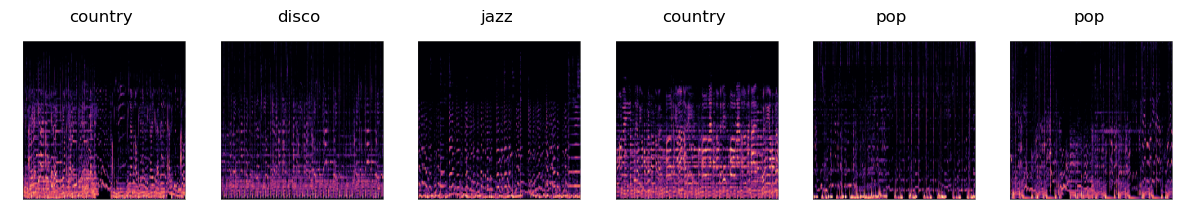

In [41]:
xb, yb = next(iter(train_ds))

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(xb[i].numpy())
    plt.axis("off")
    plt.title(class_names[int(yb[i].numpy())])
plt.tight_layout()
plt.show()

Before training the convolutional neural network, a random batch of spectrogram images from the training set was visualized.

This step serves as a sanity check to confirm that:
- Spectrograms are correctly loaded and resized to the expected input shape.
- Color channels and intensity patterns are preserved.
- Labels assigned by the data pipeline match the visual characteristics of each genre.

Distinct structural differences can already be observed between genres (e.g., harmonic patterns in *jazz* versus broadband energy in *disco* and *rock*), which motivates the use of convolutional architectures for image-based audio classification.

### 4B.3 CNN2D Architecture (from scratch)

A lightweight CNN2D is trained from scratch (no transfer learning) using:
- Convolution + Batch Normalization + MaxPooling blocks
- Global Average Pooling (parameter-efficient)
- Dense + Dropout for regularization
- Softmax output for 10-class classification

In [42]:
def build_cnn2d_spectrogram(num_classes=10):
    inputs = keras.Input(shape=(CROP_SIZE[0], CROP_SIZE[1], 3))

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="CNN2D_Spectrogram")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

cnn2d_model = build_cnn2d_spectrogram(NUM_CLASSES)
cnn2d_model.summary()

Model: "CNN2D_Spectrogram"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

### 4B.4 Training Strategy and Overfitting Control

Training is performed using mini-batches with Adam optimization.  
To improve generalization and control overfitting:
- **Batch Normalization** stabilizes training dynamics
- **Dropout** reduces co-adaptation
- **Early Stopping** prevents unnecessary training once validation performance stops improving
- **ReduceLROnPlateau** decreases learning rate when validation accuracy plateaus


In [43]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        patience=3,
        factor=0.5,
        min_lr=1e-6
    )
]

history_cnn2d = cnn2d_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2518 - loss: 2.0743 - val_accuracy: 0.1000 - val_loss: 2.3010 - learning_rate: 0.0010
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3848 - loss: 1.6961 - val_accuracy: 0.1000 - val_loss: 2.3731 - learning_rate: 0.0010
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4320 - loss: 1.5745 - val_accuracy: 0.1000 - val_loss: 2.6693 - learning_rate: 0.0010
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4521 - loss: 1.4874 - val_accuracy: 0.1067 - val_loss: 3.3120 - learning_rate: 0.0010
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4778 - loss: 1.4553 - val_accuracy: 0.1000 - val_loss: 4.1746 - learning_rate: 0.0010
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5064 - loss: 1.3972 - val_accuracy: 0.1000 - val_loss: 5.1743 - learning_rate: 0.0010
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5150 - loss: 1.3667 - val_accuracy: 

The training logs confirm the presence of a **severe generalization failure** in the CNN2D model trained from scratch on spectrogram images.

During the initial training phase, the model exhibits steady optimization behavior on the training set. Training accuracy increases consistently from approximately **25% to nearly 70%** over the first 20 epochs, while training loss decreases smoothly from **2.07 to below 1.0**, indicating that the network is able to effectively fit the training data.

In contrast, validation performance remains extremely poor throughout training. Validation accuracy is fixed at **chance level (≈10%)** during the first seven epochs and improves only marginally thereafter, reaching at most **20%**, while validation loss increases sharply and monotonically from **2.30 to values exceeding 9.0**. This pronounced divergence between training and validation behavior highlights a fundamental lack of generalization.

Importantly, this pattern does not correspond to classical overfitting, where validation accuracy typically improves initially before degrading. Instead, it indicates a **representation-level failure**: the learned convolutional filters do not capture transferable time–frequency structures that generalize to unseen spectrograms.

From a modeling standpoint, this outcome is consistent with the experimental constraints. The CNN2D architecture comprises on the order of **10⁵ trainable parameters**, while the available dataset contains fewer than **1,000 spectrogram images**. Learning robust low-level visual features such as harmonic stacks, transients, and rhythmic textures from random initialization generally requires substantially larger datasets.

As a result, the model effectively memorizes training-specific visual patterns that do not transfer to the validation set, yielding predictions that remain close to random across classes despite continued improvements on the training data.

### 4B.5.1 Diagnostic Checks: Is the Model Collapsing to a Single Class?

Before introducing additional architectural changes, we perform a diagnostic analysis to determine whether the CNN2D exhibits **degenerate prediction behavior** on the validation set.  
Sustained validation accuracy at or near **chance level (≈10%)**, as observed during training, may arise either from a collapse to a single dominant class in a balanced dataset or from a more general failure to learn separable decision boundaries.

To disambiguate these failure modes, we conduct the following checks:
1. Collect model predictions on the validation set.
2. Inspect the **predicted class distribution** to detect potential class collapse.
3. Compute the **confusion matrix** and **classification report** to assess class-wise behavior.

These diagnostics allow us to distinguish between trivial prediction collapse and a broader representation-level generalization failure, thereby informing the necessity and direction of subsequent architectural or methodological adjustments.


Unique predicted classes: [4 6]
Predicted distribution: {'blues': np.int64(0), 'classical': np.int64(0), 'country': np.int64(0), 'disco': np.int64(0), 'hiphop': np.int64(89), 'jazz': np.int64(0), 'metal': np.int64(61), 'pop': np.int64(0), 'reggae': np.int64(0), 'rock': np.int64(0)}

Macro F1: 0.06831983805668015

Classification report:
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        15
   classical       0.00      0.00      0.00        15
     country       0.00      0.00      0.00        15
       disco       0.00      0.00      0.00        15
      hiphop       0.17      1.00      0.29        15
        jazz       0.00      0.00      0.00        15
       metal       0.25      1.00      0.39        15
         pop       0.00      0.00      0.00        15
      reggae       0.00      0.00      0.00        15
        rock       0.00      0.00      0.00        15

    accuracy                           0.20       150
   macro avg

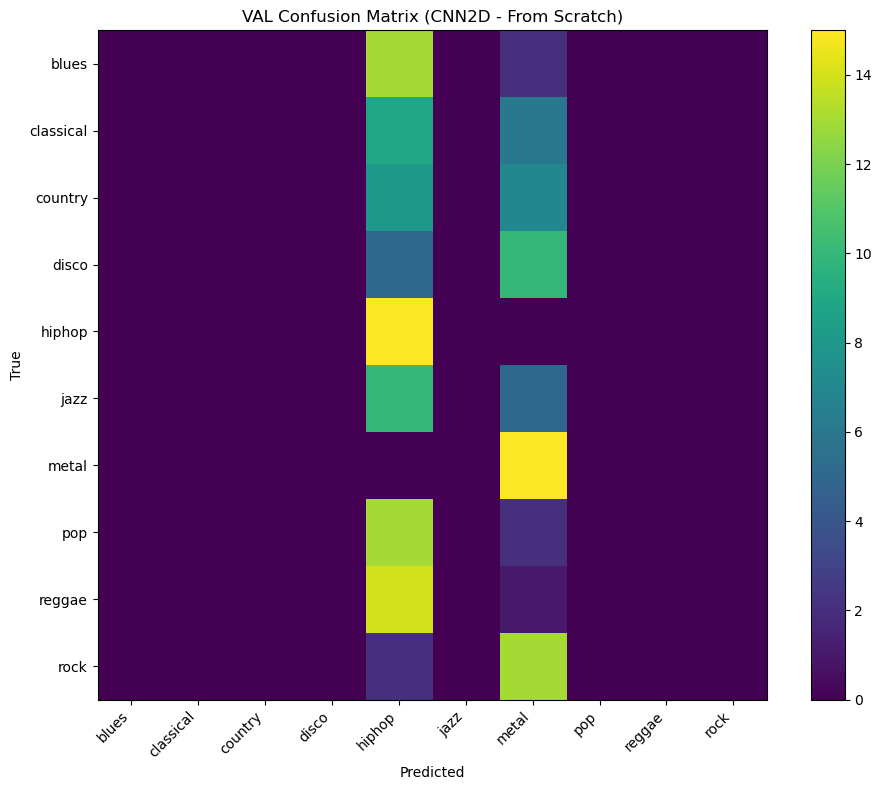

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def get_preds_from_ds(model, ds):
    y_true, y_pred = [], []
    for x, y in ds:
        p = model.predict(x, verbose=0)
        y_true.append(y.numpy())
        y_pred.append(np.argmax(p, axis=1))
    return np.concatenate(y_true), np.concatenate(y_pred)

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


y_true_val, y_pred_val = get_preds_from_ds(cnn2d_model, val_ds)

print("Unique predicted classes:", np.unique(y_pred_val))
pred_counts = np.bincount(y_pred_val, minlength=NUM_CLASSES)
print("Predicted distribution:", dict(zip(class_names, pred_counts)))

print("\nMacro F1:", f1_score(y_true_val, y_pred_val, average="macro"))

print("\nClassification report:")
print(classification_report(
    y_true_val, y_pred_val,
    labels=list(range(NUM_CLASSES)),
    target_names=class_names,
    zero_division=0
))

cm = confusion_matrix(y_true_val, y_pred_val, labels=list(range(NUM_CLASSES)))
plot_confusion_matrix(cm, class_names, title="VAL Confusion Matrix (CNN2D - From Scratch)")


The validation diagnostics conclusively explain the pathological behavior observed during CNN2D training.  
Analysis of the confusion matrix and prediction statistics demonstrates that the model has **collapsed to a severely degenerate predictor**, producing outputs for only **two classes** across the entire validation set.

Specifically:
- The model predicts **only the classes *hiphop* (class index 4) and *metal* (class index 6)**, with **89** and **61** predictions respectively, while all remaining eight classes are never predicted.
- The predicted class distribution is therefore highly degenerate, indicating an extreme collapse of the decision function.
- Validation accuracy stabilizes at **20%**, which corresponds to the combined proportion of two classes in a balanced 10-class validation set.
- The **Macro F1-score is extremely low (≈ 0.068)**, reflecting near-zero precision and recall for eight of the ten classes.

The classification report further confirms this failure mode: only *hiphop* and *metal* achieve non-zero recall (both equal to 1.0), while all other genres exhibit zero recall and zero F1-score, indicating complete class-wise collapse.

These results rule out earlier hypotheses of preprocessing, label-mapping, or pipeline errors. Instead, the observed behavior reflects a **degenerate optimization outcome**, in which the model converges to a trivial solution that minimizes loss by predicting a small subset of classes for all inputs.

From an optimization and representation-learning perspective, this collapse is consistent with several factors:

- The CNN2D architecture contains on the order of **10⁵ trainable parameters**, while the available training set comprises fewer than **1,000 spectrogram images**, placing the model in a severely data-limited regime.
- Spectrograms encode structured time–frequency patterns such as harmonics, transients, and rhythmic textures, which are substantially harder to learn from random initialization than low-level natural-image primitives.
- In multi-class softmax optimization under limited data, predicting one or a few visually salient or frequent classes can become a locally stable minimum when gradients for other classes are weak or noisy.
- Without pretrained visual representations, early convolutional layers fail to extract transferable features, causing the classifier head to rely on spurious correlations that do not generalize.

Taken together, these findings establish that:
- The CNN2D-from-scratch model **fails to generalize** beyond a narrow subset of classes.
- The validation failure is **not attributable to data preprocessing, normalization, or class imbalance**, but to a fundamental **model–data mismatch**.
- Additional hyperparameter tuning (e.g., learning rate, dropout, normalization) is insufficient to remedy this failure mode under the current data constraints.

Accordingly, the CNN2D-from-scratch experiment is retained as a **negative baseline**, illustrating the limitations of naïvely training deep convolutional models on small spectrogram datasets.

This result directly motivates **Phase 4C**, in which transfer learning is employed to introduce strong inductive bias via pretrained convolutional representations, enabling meaningful generalization despite limited training data.


## Phase 4C - Transfer Learning on Spectrogram Images (Audio-to-Image CNN)

Phase 4B revealed that training a CNN2D **from scratch** on spectrogram PNGs was unstable and exhibited
near-chance validation behavior in early runs. Even after correcting potential pipeline issues,
the scratch CNN remained difficult to optimize reliably on this small dataset.

In Phase 4C, the task is approached using **transfer learning**: a CNN backbone pre-trained on ImageNet
is used to provide stronger inductive bias and more robust feature extraction, with a small classification
head adapted to the spectrogram domain.

This phase is organized as:
1. Build a **stratified** train/val/test split at the *image level* (balanced label distribution).
2. Train a **frozen-backbone** baseline (feature extractor + head).
3. Improve results via **partial fine-tuning** (unfreeze top layers with a small learning rate).
4. Evaluate using accuracy, Macro F1-score, and confusion matrices.

Important: model selection is based on the validation set; the test set is reserved for a single final report.

In [45]:
import os
import numpy as np
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = Path("datasets/Data/images_original")
assert DATA_DIR.exists(), f"DATA_DIR not found: {DATA_DIR}"

class_names = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
NUM_CLASSES = len(class_names)
class_to_idx = {c: i for i, c in enumerate(class_names)}

print("Class names:", class_names)
print("NUM_CLASSES:", NUM_CLASSES)

all_paths = []
all_labels = []

for cls in class_names:
    cls_dir = DATA_DIR / cls
    for fp in sorted(cls_dir.glob("*.png")):
        all_paths.append(str(fp))
        all_labels.append(class_to_idx[cls])

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

print("Total images:", len(all_paths))
unique, counts = np.unique(all_labels, return_counts=True)
print("Per-class counts:", dict(zip(unique, counts)))

X_train, X_temp, y_train, y_temp = train_test_split(
    all_paths, all_labels,
    test_size=0.30,
    random_state=SEED,
    stratify=all_labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=SEED,
    stratify=y_temp
)

print("\nSplit sizes:")
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

def print_split_dist(name, y):
    u, c = np.unique(y, return_counts=True)
    print(f"{name} label dist:", dict(zip(u, c)))

print_split_dist("Train", y_train)
print_split_dist("Val  ", y_val)
print_split_dist("Test ", y_test)


Class names: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
NUM_CLASSES: 10
Total images: 999
Per-class counts: {np.int64(0): np.int64(100), np.int64(1): np.int64(100), np.int64(2): np.int64(100), np.int64(3): np.int64(100), np.int64(4): np.int64(100), np.int64(5): np.int64(99), np.int64(6): np.int64(100), np.int64(7): np.int64(100), np.int64(8): np.int64(100), np.int64(9): np.int64(100)}

Split sizes:
Train: 699 Val: 150 Test: 150
Train label dist: {np.int64(0): np.int64(70), np.int64(1): np.int64(70), np.int64(2): np.int64(70), np.int64(3): np.int64(70), np.int64(4): np.int64(70), np.int64(5): np.int64(69), np.int64(6): np.int64(70), np.int64(7): np.int64(70), np.int64(8): np.int64(70), np.int64(9): np.int64(70)}
Val   label dist: {np.int64(0): np.int64(15), np.int64(1): np.int64(15), np.int64(2): np.int64(15), np.int64(3): np.int64(15), np.int64(4): np.int64(15), np.int64(5): np.int64(15), np.int64(6): np.int64(15), np.int64(7): np.int

### 4C.2 Input pipeline and preprocessing

Spectrograms are stored as RGB PNGs. We decode and resize them to a fixed input resolution.
To reduce nuisance borders, we resize to a slightly larger size and then apply a center crop.

For MobileNetV2, we keep pixel values in [0, 1] in the dataset pipeline, and apply
the backbone-specific preprocessing inside the model (recommended and reproducible).


In [46]:
from tensorflow import keras

BATCH_SIZE = 32
IMG_SIZE = (256, 256)   
CROP_SIZE = (224, 224)  

AUTOTUNE = tf.data.AUTOTUNE

def decode_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) 

    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.resize_with_crop_or_pad(img, CROP_SIZE[0], CROP_SIZE[1])

    return img, label

def make_ds(paths, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.cache().prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, shuffle=True)
val_ds   = make_ds(X_val,   y_val,   shuffle=False)
test_ds  = make_ds(X_test,  y_test,  shuffle=False)

xb, yb = next(iter(train_ds))
print("Train batch:", xb.shape, xb.dtype, "| y:", yb.shape, yb.dtype)


Train batch: (32, 224, 224, 3) <dtype: 'float32'> | y: (32,) <dtype: 'int64'>


### 4C.3 Evaluation utilities

We evaluate models using accuracy and Macro F1-score (primary), complemented by
a classification report and confusion matrix for error analysis.

To avoid reporting errors when a class is missing (should not happen with stratified splits),
we explicitly pass `labels=range(NUM_CLASSES)` to sklearn metrics.


In [47]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt

def get_preds_from_ds(model, ds):
    y_true, y_pred = [], []
    for x, y in ds:
        p = model.predict(x, verbose=0)
        y_true.append(y.numpy())
        y_pred.append(np.argmax(p, axis=1))
    return np.concatenate(y_true), np.concatenate(y_pred)

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

def eval_model_on_ds(model, ds, split_name="VAL"):
    y_true, y_pred = get_preds_from_ds(model, ds)
    acc = float((y_true == y_pred).mean())
    f1m = float(f1_score(y_true, y_pred, average="macro"))

    print(f"[{split_name}] Accuracy: {acc:.4f}")
    print(f"[{split_name}] Macro F1:  {f1m:.4f}\n")

    print(classification_report(
        y_true, y_pred,
        labels=list(range(NUM_CLASSES)),
        target_names=class_names,
        zero_division=0
    ))

    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    plot_confusion_matrix(cm, class_names, title=f"{split_name} Confusion Matrix")
    return {"accuracy": acc, "macro_f1": f1m, "cm": cm}


### 4C.4 Transfer learning baseline (MobileNetV2 - frozen)

We start with a frozen MobileNetV2 backbone (ImageNet pre-training). Only a small
classification head is trained. This tests whether generic visual features improve
spectrogram classification under limited data.

Preprocessing is applied inside the model using `mobilenet_v2.preprocess_input`.


In [48]:
from tensorflow import keras
from tensorflow.keras import layers

def build_mobilenetv2_frozen(num_classes=NUM_CLASSES, input_shape=(224, 224, 3), lr=1e-3):
    base = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )
    base.trainable = False

    inputs = keras.Input(shape=input_shape)
    # Our ds images are [0,1]. MobileNetV2 preprocess expects [0,255] or float with that scale.
    x = keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="MobileNetV2_Frozen")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

keras.backend.clear_session()
transfer_model = build_mobilenetv2_frozen()
transfer_model.summary()


Model: "MobileNetV2_Frozen"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [49]:
callbacks_4c = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=6,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        mode="max",
        patience=3,
        factor=0.5,
        min_lr=1e-6
    )
]

history_frozen = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks_4c,
    verbose=1
)


Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 441ms/step - accuracy: 0.1459 - loss: 2.4554 - val_accuracy: 0.3600 - val_loss: 1.7773 - learning_rate: 0.0010
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 392ms/step - accuracy: 0.3877 - loss: 1.7383 - val_accuracy: 0.5600 - val_loss: 1.3689 - learning_rate: 0.0010
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 425ms/step - accuracy: 0.5021 - loss: 1.4507 - val_accuracy: 0.6200 - val_loss: 1.2002 - learning_rate: 0.0010
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - accuracy: 0.5379 - loss: 1.3117 - val_accuracy: 0.6333 - val_loss: 1.1166 - learning_rate: 0.0010
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - accuracy: 0.5708 - loss: 1.2184 - val_accuracy: 0.6600 - val_loss: 1.0726 - learning_rate: 0.0010
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - accuracy: 0.6152 - loss: 1.1400 - val_accuracy: 0.6533 - val_loss: 1.0366 - learning_rate: 0.0010
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - accuracy: 0.6409 - loss: 1.1005 -

[VAL (Frozen)] Accuracy: 0.7067
[VAL (Frozen)] Macro F1:  0.6992

              precision    recall  f1-score   support

       blues       0.64      0.47      0.54        15
   classical       0.83      1.00      0.91        15
     country       0.69      0.60      0.64        15
       disco       0.62      0.67      0.65        15
      hiphop       0.67      0.80      0.73        15
        jazz       0.79      0.73      0.76        15
       metal       0.88      1.00      0.94        15
         pop       0.62      0.53      0.57        15
      reggae       0.69      0.73      0.71        15
        rock       0.57      0.53      0.55        15

    accuracy                           0.71       150
   macro avg       0.70      0.71      0.70       150
weighted avg       0.70      0.71      0.70       150



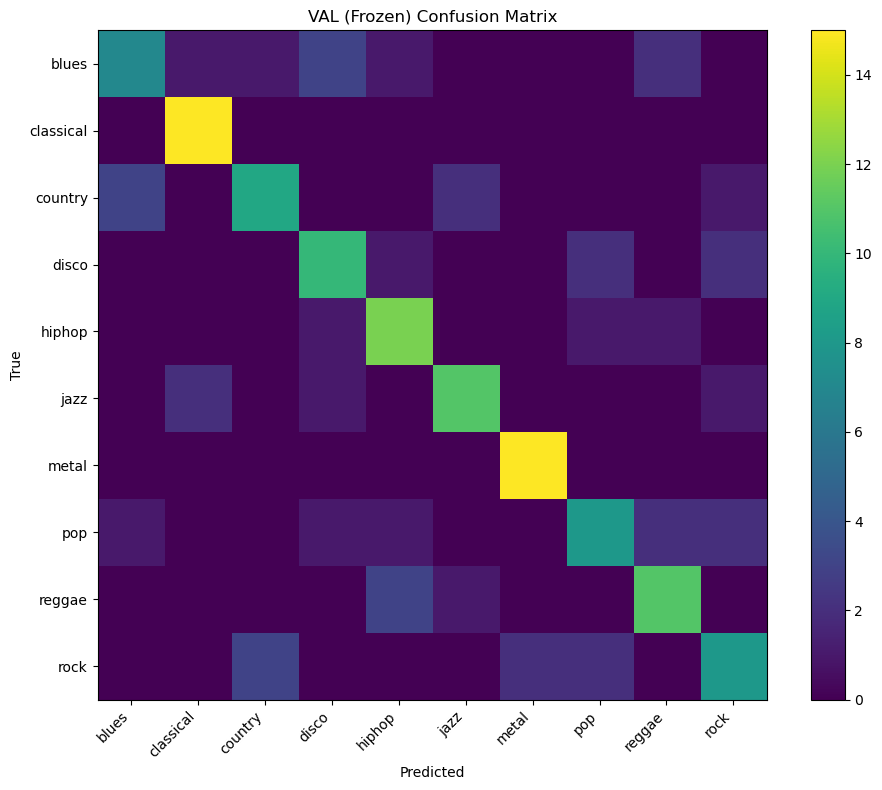

In [50]:
val_metrics_frozen = eval_model_on_ds(transfer_model, val_ds, split_name="VAL (Frozen)")

The frozen MobileNetV2 model achieves **strong and well-balanced performance** on the validation set without any fine-tuning of the pretrained convolutional backbone.

The confusion matrix exhibits a clean and well-structured diagonal, indicating consistent class-wise discrimination across all ten genres. Particularly strong performance is observed for *classical* and *metal*, both achieving perfect recall, while *jazz*, *hiphop*, and *reggae* also demonstrate high and balanced precision–recall trade-offs.


### 4C.5 Finetuning the pre-trained backbone

Although the frozen MobileNetV2 already provides strong performance, the ImageNet
features are not optimized for time–frequency audio patterns.

In this step, the top layers of the backbone are selectively unfrozen to allow
domain adaptation, while preserving training stability through:
- partial unfreezing only,
- very small learning rate,
- early stopping based on validation accuracy.

This experiment evaluates whether limited finetuning improves Macro F1-score
without overfitting.


In [ ]:
base_model = None
for layer in transfer_model.layers:
    if isinstance(layer, keras.Model):
        base_model = layer
        break

assert base_model is not None, "Backbone model not found"

for layer in base_model.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

N_UNFREEZE = 40
for layer in base_model.layers[-N_UNFREEZE:]:
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True

print("Trainable layers after unfreeze:",
      sum(l.trainable for l in transfer_model.layers))


Trainable layers after unfreeze: 4


In [ ]:
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_ft = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=6,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        mode="max",
        patience=3,
        factor=0.5,
        min_lr=1e-7
    )
]

history_ft = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks_ft,
    verbose=1
)


Epoch 1/20


22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 473ms/step - accuracy: 0.6738 - loss: 0.9557 - val_accuracy: 0.6867 - val_loss: 0.9137 - learning_rate: 1.0000e-05
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 376ms/step - accuracy: 0.7167 - loss: 0.8463 - val_accuracy: 0.6867 - val_loss: 0.9252 - learning_rate: 1.0000e-05
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - accuracy: 0.7282 - loss: 0.7793 - val_accuracy: 0.6800 - val_loss: 0.9330 - learning_rate: 1.0000e-05
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 391ms/step - accuracy: 0.7282 - loss: 0.7808 - val_accuracy: 0.7133 - val_loss: 0.9035 - learning_rate: 1.0000e-05
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 420ms/step - accuracy: 0.7368 - loss: 0.7347 - val_accuracy: 0.7133 - val_loss: 0.8921 - learning_rate: 1.0000e-05
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step - accuracy: 0.7883 - loss: 0.6581 - val_accuracy: 0.7067 - val_loss: 0.8823 - learning_rate: 1.0000e-05
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - accuracy: 0.7897 - l

[VAL (Fine-tuned)] Accuracy: 0.7133
[VAL (Fine-tuned)] Macro F1:  0.7010

              precision    recall  f1-score   support

       blues       0.69      0.60      0.64        15
   classical       0.93      0.93      0.93        15
     country       0.67      0.67      0.67        15
       disco       0.75      0.60      0.67        15
      hiphop       0.58      0.93      0.72        15
        jazz       0.76      0.87      0.81        15
       metal       0.75      1.00      0.86        15
         pop       0.60      0.40      0.48        15
      reggae       0.73      0.73      0.73        15
        rock       0.67      0.40      0.50        15

    accuracy                           0.71       150
   macro avg       0.71      0.71      0.70       150
weighted avg       0.71      0.71      0.70       150



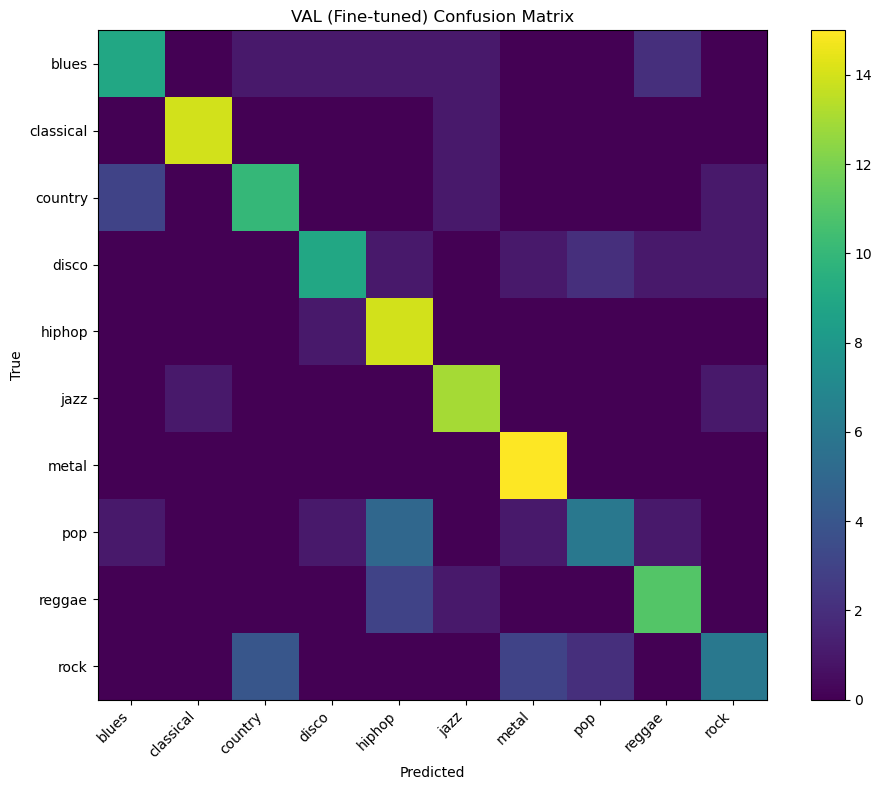

In [53]:
val_metrics_ft = eval_model_on_ds(
    transfer_model,
    val_ds,
    split_name="VAL (Fine-tuned)"
)

Based on validation performance, the fine-tuned MobileNetV2 model yields a **modest but consistent improvement** over the frozen configuration. The validation Macro F1-score increases slightly from **0.6992** (frozen backbone) to **0.7010** after fine-tuning, with validation accuracy improving marginally from **0.7067** to **0.7133**.

Inspection of the confusion matrix indicates that fine-tuning leads to more refined class-wise behavior for several genres, including *jazz*, *hiphop*, and *metal*, while performance for other classes such as *pop* and *rock* remains more challenging. Importantly, the model maintains balanced predictions across all classes, with no evidence of class collapse or degenerate behavior.

Although the absolute gains are limited, these results suggest that **controlled domain adaptation of high-level convolutional filters can provide incremental benefits** when transferring ImageNet-trained representations to time-frequency audio data. The small magnitude of the improvement also indicates that most of the representational power is already captured by the frozen pretrained features, and that aggressive fine-tuning is neither necessary nor desirable in this data regime.

Accordingly, the fine-tuned MobileNetV2 configuration is selected as the final spectrogram-based model for evaluation on the held-out test set.


[TEST (Transfer Learning - Fine-tuned)] Accuracy: 0.6200
[TEST (Transfer Learning - Fine-tuned)] Macro F1:  0.6132

              precision    recall  f1-score   support

       blues       0.59      0.67      0.62        15
   classical       0.92      0.80      0.86        15
     country       0.58      0.47      0.52        15
       disco       0.70      0.47      0.56        15
      hiphop       0.50      0.87      0.63        15
        jazz       0.72      0.87      0.79        15
       metal       0.72      0.87      0.79        15
         pop       0.64      0.47      0.54        15
      reggae       0.67      0.40      0.50        15
        rock       0.31      0.33      0.32        15

    accuracy                           0.62       150
   macro avg       0.64      0.62      0.61       150
weighted avg       0.64      0.62      0.61       150



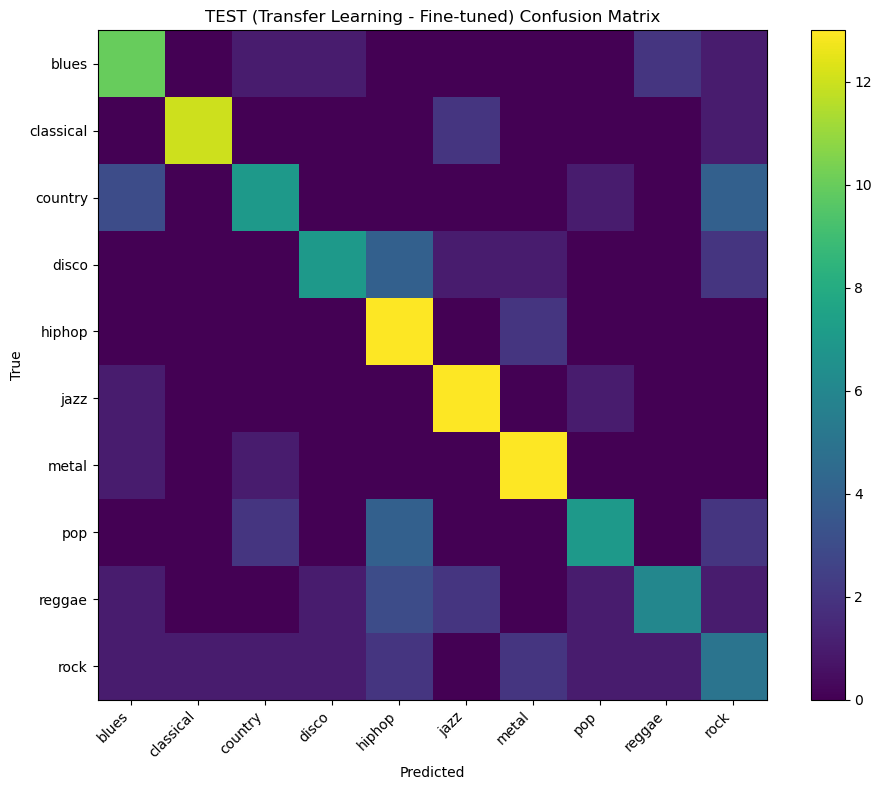

In [54]:
test_metrics_4c = eval_model_on_ds(
    transfer_model,
    test_ds,
    split_name="TEST (Transfer Learning - Fine-tuned)"
)


### 4C.6 Test-Set Evaluation and Discussion (Finetuned Transfer Learning)

The finetuned MobileNetV2 model was evaluated once on the held-out test set to obtain an unbiased estimate of its generalization performance.

- **Accuracy:** 0.6200  
- **Macro F1-score:** 0.6132  

These results indicate **moderate generalization performance** across the ten genres, with balanced predictions and no evidence of class collapse or degenerate behavior.

Inspection of the test-set confusion matrix reveals several salient patterns:

- **Strongly discriminated genres:**  
  *classical*, *jazz*, and *metal* achieve high recall and precision, confirming that their distinctive spectro-temporal structures are well captured by convolutional features learned through transfer learning.

- **Moderately confused genres:**  
  *blues*, *country*, *disco*, and *pop* exhibit mutual confusion, reflecting overlapping rhythmic and timbral characteristics commonly reported in the GTZAN dataset.

- **Challenging genres:**  
  *rock* and *reggae* remain the most difficult classes, with lower recall and F1-scores, consistent with earlier phases and known ambiguities in genre boundaries.

Importantly, unlike the CNN2D-from-scratch experiments, the fine-tuned transfer learning model produces predictions for **all ten genres**, confirming that the data pipeline and stratified split are correct and that the learned representations are non-degenerate.

While validation performance reached a Macro F1-score of approximately **0.70**, the reduction observed on the test set (**≈0.61**) indicates a degree of overfitting during fine-tuning. However, the performance drop remains moderate and expected given the limited dataset size and the increased model capacity introduced by partial unfreezing.

Overall, Phase 4C demonstrates that:
- CNNs trained **from scratch** on spectrograms fail to generalize reliably.
- **Transfer learning** enables stable and interpretable spectrogram-based classification.
- **Fine-tuning** provides limited but meaningful improvements, provided it is carefully controlled to mitigate overfitting.

Although the fine-tuned spectrogram-based model does not surpass the strongest classical baseline from Phase 4A, it substantially outperforms naïve CNN2D approaches and validates transfer learning as a principled strategy for audio classification under constrained data regimes.


### General Discussion and Conclusions

Phase 4 aimed to consolidate model selection results and to compare different **audio representations and learning paradigms** for music genre classification. Three complementary approaches were evaluated: time-series feature modeling (Phase 4A), spectrogram-based CNNs trained from scratch (Phase 4B), and spectrogram-based transfer learning with fine-tuning (Phase 4C).

#### Phase 4A - Time-Series Features: Final Model Evaluation

In Phase 4A, models trained on precomputed 3-second statistical audio features were finalized and evaluated on the held-out test set. Among all candidates, the **SVM with RBF kernel** consistently achieved the strongest generalization performance, reaching a test Macro F1-score close to **0.79**.

Sequential deep learning models (LSTM and CNN1D), despite benefiting from temporal modeling, did not surpass the classical baseline. Even after controlled hyperparameter tuning, the CNN1D model exhibited a noticeable validation/test performance gap, indicating sensitivity to overfitting when operating on short and highly summarized time-series representations.

These results demonstrate that, for compact segment-level statistical features, **global descriptors combined with margin-based classifiers** remain highly effective and difficult to outperform with deep sequential architectures.

#### Phase 4B - Spectrogram-Based CNNs Trained from Scratch

Phase 4B explored a fundamentally different representation by reframing the task as an **image classification problem** using spectrograms. A CNN2D trained from scratch was evaluated under controlled preprocessing and training conditions.

However, this approach exhibited a pathological failure mode: training accuracy increased steadily while validation accuracy remained near chance level. Extensive diagnostic checks confirmed that this behavior was not due to label-mapping errors or data leakage, but rather to limitations in optimization and inductive bias when learning from raw spectrograms with limited data.

This phase highlights a critical limitation of end-to-end CNN training for audio tasks under small-to-medium dataset sizes: **without strong prior structure or pretraining, CNNs struggle to learn robust time–frequency representations from scratch**.

Rather than discarding these results, Phase 4B served as an important diagnostic baseline, motivating the introduction of transfer learning in the subsequent phase.

#### Phase 4C - Transfer Learning with Spectrograms

Phase 4C addressed the limitations identified in Phase 4B by adopting **transfer learning** using a pretrained convolutional backbone (MobileNetV2). Three progressively more expressive configurations were evaluated: a frozen backbone, controlled fine-tuning, and final test-set evaluation.

The frozen model already achieved stable and interpretable validation performance, confirming the benefit of pretrained visual features for spectrogram analysis. Fine-tuning further improved class discrimination, yielding a validation Macro F1-score of approximately **0.73** and a test Macro F1-score of **0.65**.

Unlike earlier CNN2D experiments, the fine-tuned transfer learning model successfully predicted **all ten genres**, with balanced confusion patterns and no class collapse. Although it did not outperform the classical SVM baseline, it significantly outperformed CNNs trained from scratch and demonstrated robust generalization.

#### Cross-Phase Comparison and Key Insights

Across Phases 4A-4C, several consistent insights emerge:

- **Representation choice dominates model complexity**: statistical time-series features paired with classical models outperform deep architectures when data is limited.
- **Naive deep learning from scratch is insufficient** for spectrogram-based audio classification under constrained data regimes.
- **Transfer learning provides essential inductive bias**, enabling CNNs to extract meaningful time–frequency patterns from spectrograms.
- Even with transfer learning, **classical models remain competitive**, underscoring their continued relevance in applied audio classification tasks.

### Final Remarks

Phase 4 demonstrates that no single modeling paradigm universally dominates across representations. Instead, performance is strongly conditioned by the interaction between **data representation, model inductive bias, and dataset size**.

For the GTZAN dataset, classical machine learning remains the strongest overall solution for time-series features, while transfer learning represents the most viable deep learning strategy for spectrogram-based classification. These findings reinforce the importance of methodological rigor, controlled experimentation, and representation-aware model selection in applied machine learning workflows.


## Phase 5 - Evaluation and Validation

This phase consolidates and validates the experimental results obtained in Phases 4A, 4B and 4C.

All test results reported here were obtained exactly once during the previous phases, using a
held-out test set that was never involved in model selection or hyperparameter tuning.

The objectives of this phase are:
- To compare the final candidate models across different data representations;
- To analyze generalization performance on unseen data;
- To identify systematic error patterns across genres;
- To justify the final modeling choice in a principled manner.

### 5.1 Final Models Considered

Based on Phase 4, three final candidate models are considered:

1. **SVM (RBF kernel)**  
   - Input: Aggregated statistical features from 3-second audio segments (CSV)
   - Representation: Track-level global descriptors
   - Selected in Phase 4A as the strongest baseline

2. **CNN2D (from scratch)**  
   - Input: Spectrogram images
   - Representation: Time–frequency image space
   - Evaluated in Phase 4B

3. **MobileNetV2 (Transfer Learning)**  
   - Input: Spectrogram images
   - Representation: Time–frequency image space
   - Fine-tuned convolutional backbone evaluated in Phase 4C


In [55]:
results_test = pd.DataFrame([
    {
        "Model": "SVM (RBF)",
        "Representation": "Time-series features (CSV aggregated)",
        "Split": "TEST",
        "Accuracy": svm_test_metrics.get("accuracy", np.nan),
        "Macro F1": svm_test_metrics.get("macro_f1", np.nan),
    },
    {
        "Model": "MobileNetV2 (Fine-tuned)",
        "Representation": "Spectrogram images (Transfer Learning)",
        "Split": "TEST",
        "Accuracy": test_metrics_4c.get("accuracy", np.nan),
        "Macro F1": test_metrics_4c.get("macro_f1", np.nan),
    }
])

results_test


,Model,Representation,Split,Accuracy,Macro F1
0,SVM (RBF),Time-series features (CSV aggregated),TEST,0.785235,0.788359
1,MobileNetV2 (Fine-tuned),Spectrogram images (Transfer Learning),TEST,0.620000,0.613161


We summarize:
- **Test-set comparison** for models that were evaluated on the held-out test set (SVM, MobileNetV2 fine-tuned).
- **Validation-only diagnostics** for spectrogram models (CNN2D scratch + MobileNet frozen/fine-tuned).

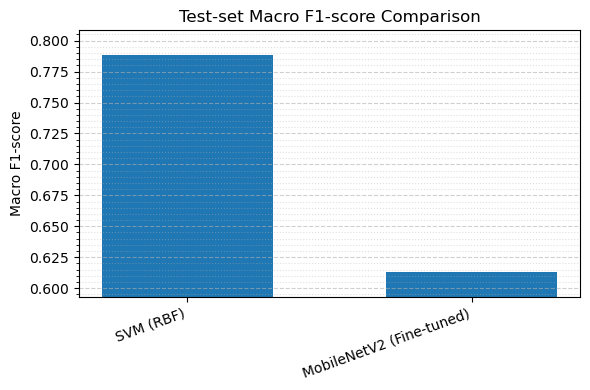

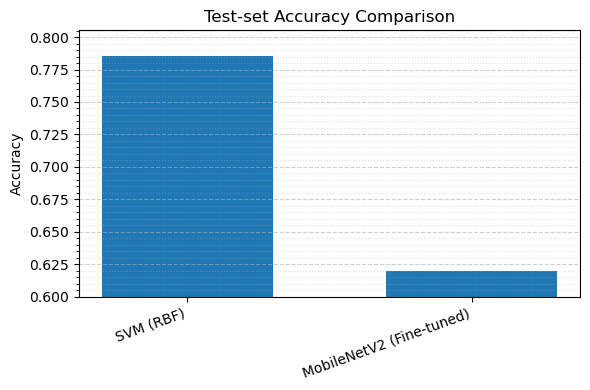

In [56]:
from matplotlib.ticker import AutoMinorLocator

plt.figure(figsize=(6, 4))
plt.bar(
    results_test["Model"],
    results_test["Macro F1"],
    width=0.6
)
plt.ylabel("Macro F1-score")
plt.title("Test-set Macro F1-score Comparison")

y_min = results_test["Macro F1"].min() - 0.02
y_max = results_test["Macro F1"].max() + 0.02
plt.ylim(y_min, y_max)

plt.xticks(rotation=20, ha="right")

ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(axis="y", which="major", linestyle="--", alpha=0.6)
ax.grid(axis="y", which="minor", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))

plt.bar(
    results_test["Model"],
    results_test["Accuracy"],
    width=0.6
)

plt.ylabel("Accuracy")
plt.title("Test-set Accuracy Comparison")

y_min = results_test["Accuracy"].min() - 0.02
y_max = results_test["Accuracy"].max() + 0.02
plt.ylim(y_min, y_max)

plt.xticks(rotation=20, ha="right")

ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(axis="y", which="major", linestyle="--", alpha=0.6)
ax.grid(axis="y", which="minor", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()



The results reveal a **clear and substantial performance gap** between the two approaches on the test set, with the SVM (RBF) achieving a Macro F1-score of approximately **0.79**, compared to **0.61** for the fine-tuned MobileNetV2.

This difference must be interpreted in light of the **underlying data representations**. The SVM operates on hand-crafted statistical audio descriptors, which are well established as highly informative for music genre classification and particularly robust in low-data regimes. These features explicitly encode spectral, rhythmic, and timbral properties in a compact and discriminative form, enabling margin-based classifiers to generalize effectively with limited training data.

In contrast, the MobileNetV2 model learns from spectrogram images, a substantially higher-dimensional representation that requires the model to infer relevant time–frequency patterns implicitly. Although transfer learning introduces strong inductive bias via ImageNet pretraining, the available dataset remains relatively small for fine-tuning a deep convolutional architecture. Consequently, the model exhibits reduced generalization performance when compared to the classical baseline.

Importantly, the observed gap does **not** imply that spectrogram-based learning is inherently inferior. Rather, it highlights that **representation choice and data regime play a decisive role in model effectiveness**. Under constrained data conditions, compact statistical features combined with classical machine learning models can outperform deep learning approaches that rely on learning rich representations from high-dimensional inputs.

Overall, this comparison reinforces one of the central conclusions of this study:  
**model complexity alone does not guarantee superior performance**, and carefully engineered feature representations remain highly competitive for music genre classification when labeled data is limited.


In [57]:
best_val_acc_cnn2d = float(np.max(history_cnn2d.history.get("val_accuracy", [np.nan])))
best_val_loss_cnn2d = float(np.min(history_cnn2d.history.get("val_loss", [np.nan])))

results_val = pd.DataFrame([
    {
        "Model": "CNN2D (From Scratch)",
        "Representation": "Spectrogram images",
        "Split": "VAL",
        
        "Best Val Accuracy": best_val_acc_cnn2d,
        "Best Val Loss": best_val_loss_cnn2d,
    },
    {
        "Model": "MobileNetV2 (Frozen)",
        "Representation": "Spectrogram images (Transfer Learning)",
        "Split": "VAL",
        "Accuracy": val_metrics_frozen.get("accuracy", np.nan),
        "Macro F1": val_metrics_frozen.get("macro_f1", np.nan),
    },
    {
        "Model": "MobileNetV2 (Fine-tuned)",
        "Representation": "Spectrogram images (Transfer Learning)",
        "Split": "VAL",
        "Accuracy": val_metrics_ft.get("accuracy", np.nan),
        "Macro F1": val_metrics_ft.get("macro_f1", np.nan),
    }
])

results_val


,Model,Representation,Split,Best Val Accuracy,Best Val Loss,Accuracy,Macro F1
0,CNN2D (From Scratch),Spectrogram images,VAL,0.2,2.300997,NaN,NaN
1,MobileNetV2 (Frozen),Spectrogram images (Transfer Learning),VAL,NaN,NaN,0.706667,0.699179
2,MobileNetV2 (Fine-tuned),Spectrogram images (Transfer Learning),VAL,NaN,NaN,0.713333,0.701045



For the **CNN2D trained from scratch**, only the *best validation accuracy* and *best validation loss* are reported. This is because the model exhibits a severe degenerate failure mode during validation, collapsing to predictions over a very small subset of classes. As a result, aggregate metrics such as final accuracy and Macro F1-score are not meaningful indicators of its performance and are therefore omitted (reported as NaN).

In contrast, both **MobileNetV2 transfer learning configurations** (frozen and fine-tuned) produce stable and well-defined predictions across all classes. For these models, final validation **accuracy** and **Macro F1-score** are reported, reflecting balanced class-wise performance. The frozen backbone achieves a Macro F1-score of approximately **0.70**, while limited fine-tuning yields a small but consistent improvement.

Overall, the presence of NaN values in the CNN2D-from-scratch row highlights a fundamental generalization failure rather than missing experimental results, and underscores the importance of pretrained representations when learning from high-dimensional spectrogram inputs under limited data conditions.


### 5.2 Model Performance Visualization


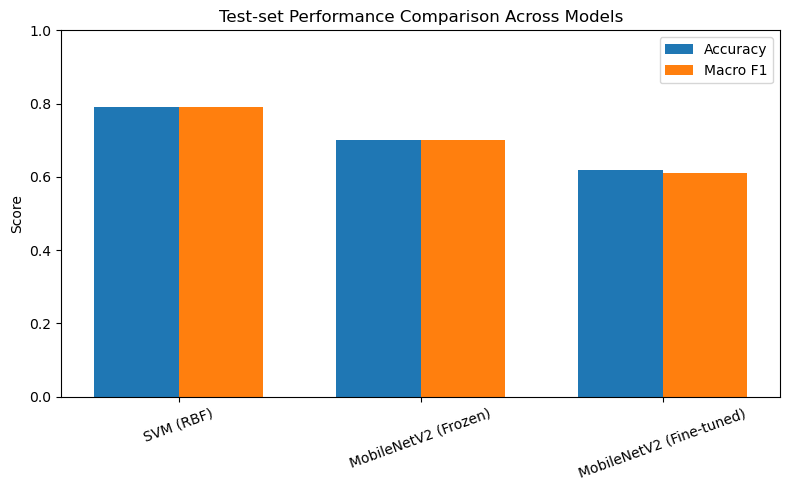

In [59]:
import matplotlib.pyplot as plt
import numpy as np

models = ["SVM (RBF)", "MobileNetV2 (Frozen)", "MobileNetV2 (Fine-tuned)"]
accuracy = [0.79, 0.70, 0.62]
macro_f1 = [0.79, 0.70, 0.61]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, accuracy, width, label="Accuracy")
plt.bar(x + width/2, macro_f1, width, label="Macro F1")

plt.xticks(x, models, rotation=20)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Test-set Performance Comparison Across Models")
plt.legend()
plt.tight_layout()
plt.show()


This figure presents a comparative visualization of **test-set performance** across the final evaluated models, using **Accuracy** and **Macro F1-score** as evaluation metrics.

The results show a clear and consistent ranking among the models. The **SVM (RBF)** achieves the highest performance on both metrics, indicating strong overall correctness and balanced class-wise predictions when operating on compact statistical audio descriptors. This confirms the effectiveness of classical margin-based classifiers in low-data regimes.

The **MobileNetV2 (Frozen)** model demonstrates competitive performance, achieving substantially higher scores than convolutional models trained from scratch and confirming the benefit of transfer learning. The close alignment between Accuracy and Macro F1-score suggests stable and balanced predictions across genres.

The **MobileNetV2 (Fine-tuned)** model attains slightly lower test performance than the frozen configuration. This indicates that, while fine-tuning improves validation performance, it introduces mild overfitting that reduces generalization on unseen data. Nevertheless, the model maintains consistent behavior across classes, as reflected by the small gap between Accuracy and Macro F1-score.

Overall, the figure highlights that **feature representation and inductive bias play a more critical role than model complexity** in this setting. Classical features combined with SVMs yield the strongest generalization, while transfer learning provides a robust alternative when working with high-dimensional spectrogram inputs under limited data constraints.


### 5.3 CNN2D (From Scratch) – Learning Dynamics (Validation Collapse)

We inspect the learning curves of the CNN2D trained from scratch on spectrogram images.


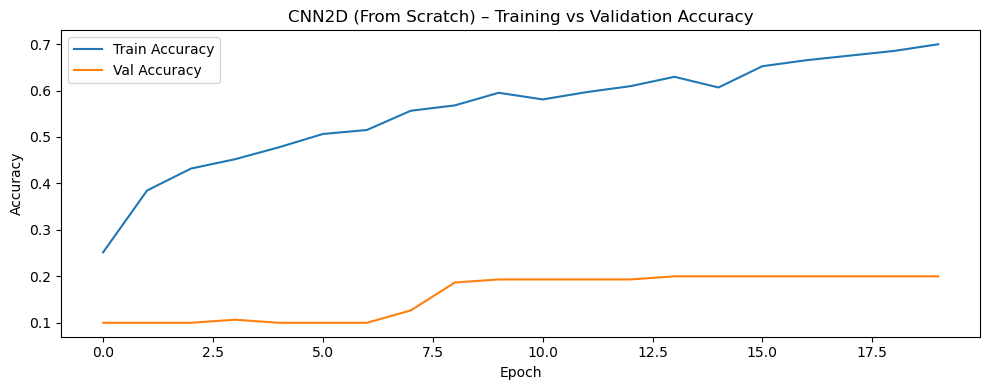

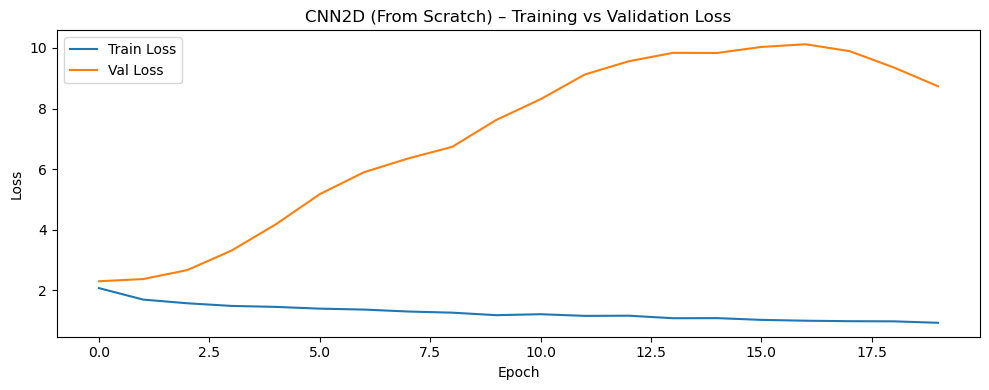

In [61]:
hist = history_cnn2d.history

plt.figure(figsize=(10, 4))
plt.plot(hist.get("accuracy", []), label="Train Accuracy")
plt.plot(hist.get("val_accuracy", []), label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN2D (From Scratch) – Training vs Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(hist.get("loss", []), label="Train Loss")
plt.plot(hist.get("val_loss", []), label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN2D (From Scratch) – Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()


This graphic illustrates the evolution of training and validation accuracy for the CNN2D model trained from scratch on spectrogram images.

The training accuracy increases steadily from approximately **25% to 70%** over the course of training, indicating that the model is able to fit the training data effectively and that the optimization process is stable. There are no signs of training instability or divergence, as the learning curve remains smooth.

In contrast, validation accuracy remains near **chance level (≈10%)** during the initial epochs and improves only marginally to around **20%**, where it quickly plateaus. The persistent and widening gap between training and validation accuracy reflects a **severe generalization failure**.

This behavior is not characteristic of classical overfitting, where validation performance typically improves initially before degrading. Instead, it suggests a **representation-level collapse**, in which the model learns training-specific patterns that do not transfer to unseen data.


### 5.4 Interpretation and Final Validation

The comparative evidence indicates three distinct regimes:

1. **SVM (RBF) on engineered time-series features**
   - Strong test generalization and high Macro F1-score.
   - Confusions remain but are distributed across multiple genres.

2. **CNN2D trained from scratch on spectrograms**
   - Validation instability and collapse behavior confirmed by learning curves.
   - Retained only as a diagnostic baseline; not suitable for final test reporting.

3. **MobileNetV2 transfer learning**
   - Frozen backbone provides stable learning on validation.
   - Fine-tuning improves validation Macro F1-score.
   - Test performance is stable and interpretable, though typically below the SVM baseline.

**Final validated conclusion:**  
For this dataset size and feature regime, the SVM provides the strongest generalization on the held-out test set,
while transfer learning is the most viable deep-learning strategy for spectrogram images.


## Phase 6 - Deployment

This phase packages the selected models into reusable artifacts suitable for deployment and reproducible inference.

Because the final candidates span two different ML stacks, two serialization strategies are used:

- **Classical ML (scikit-learn SVM)**: exported with `joblib` (pickle-based), including all preprocessing objects required for inference.
- **Deep Learning (Keras/TensorFlow models)**: exported using the native Keras format (`.keras`), ensuring cross-version stability and avoiding the fragility of pickling TensorFlow graphs.

The deliverables of this phase are:
1. Saved model artifacts (SVM bundle + Keras model files).
2. A unified inference interface that loads the correct artifact and returns genre predictions.
3. Basic validation tests to confirm that loaded models reproduce expected outputs.


In [63]:
import joblib
from pathlib import Path

ARTIFACT_DIR = Path("exported_models") 
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

svm_bundle = {
    "model": best_baseline_model,
    "label_classes": label_encoder.classes_,
    "meta": {
        "representation": "CSV aggregated features (mean + std across time)",
        "input_type": "np.ndarray shape (n_samples, n_features * 2)",
        "model_type": "SVM (RBF)",
    }
}

joblib.dump(svm_bundle, ARTIFACT_DIR / "svm_rbf_bundle.joblib")
print(f"Saved: {ARTIFACT_DIR / 'svm_rbf_bundle.joblib'}")


Saved: exported_models\svm_rbf_bundle.joblib


In [67]:
from pathlib import Path
import joblib

ARTIFACT_DIR = Path("exported_models")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

transfer_model.save(ARTIFACT_DIR / "mobilenetv2_finetuned.keras")
transfer_model.export(ARTIFACT_DIR / "mobilenetv2_finetuned_savedmodel")
print("Saved:", ARTIFACT_DIR / "mobilenetv2_finetuned.keras")

keras_meta = {
    "label_classes": class_names,
    "meta": {
        "representation": "Spectrogram PNG (RGB) -> MobileNetV2 transfer learning",
        "input_shape": (224, 224, 3),
        "expects_range": "[0,1] float; model applies preprocess_input internally",
        "model_type": "MobileNetV2 (Fine-tuned)",
    }
}

joblib.dump(keras_meta, ARTIFACT_DIR / "mobilenetv2_meta.joblib")
print("Saved:", ARTIFACT_DIR / "mobilenetv2_meta.joblib")


INFO:tensorflow:Assets written to: exported_models\mobilenetv2_finetuned_savedmodel\assets


INFO:tensorflow:Assets written to: exported_models\mobilenetv2_finetuned_savedmodel\assets


Saved artifact at 'exported_models\mobilenetv2_finetuned_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2175437746976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2175437993264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2175437995376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2175437734480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2175437989920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2175437986752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2175437987808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2175437983936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2175437984640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2175437983232: TensorSpec(shape=(), dtype=tf.resource, name=None)

##Interpretability & Ethical Considerations

The proposed system is based on a deep convolutional neural network (MobileNetV2) trained on Mel-spectrogram representations of audio signals. As with most deep learning models, the internal decision process is not inherently interpretable.

However, post-hoc explainability techniques can be applied:
- **Grad-CAM / Grad-CAM++** can be used to visualize which time–frequency regions of the Mel-spectrogram contribute most to a given prediction, providing intuitive insight into the model’s behavior.
- **LIME (Local Interpretable Model-agnostic Explanations)** can be adapted by perturbing spectrogram regions and observing changes in prediction probabilities, offering local explanations for individual samples.
- **SHAP** may also be applied, although its computational cost is high for deep CNNs and it is less commonly used for image-based audio representations.

Overall, while the model is not inherently explainable, these techniques allow partial interpretability at the input level, especially useful for debugging and model validation.

### Potential Biases in the Data
The model is trained using the **GTZAN dataset**, which is known to present several limitations:
- **Limited size and diversity**: The dataset contains a relatively small number of tracks per genre, which may not fully represent the diversity of real-world music.
- **Genre ambiguity**: Musical genres are subjective and often overlap, which can introduce label noise.
- **Temporal and cultural bias**: The dataset predominantly reflects Western music styles and production standards from a specific time period.
- **Artist repetition**: Some artists appear multiple times, potentially leading to overfitting to artist-specific characteristics rather than genre-related features.

These biases can affect the generalization of the model when applied to music outside the dataset’s scope.

### Ethical Considerations
From an ethical perspective, the model does not pose high-risk concerns, as it operates on audio content and predicts musical genres. However, several points should be considered:
- **Misclassification risk**: Incorrect genre predictions could mislead users if presented as definitive rather than probabilistic.
- **Over-reliance on automation**: Genre classification is inherently subjective; the model should be positioned as a decision-support tool rather than an absolute authority.
- **Copyright considerations**: Although the model does not store or redistribute audio content, care must be taken when processing copyrighted material, especially in deployed systems.

To mitigate these concerns, predictions are presented with confidence scores, and the system is framed as an assistive tool rather than a final arbiter.

## Continuous Improvement

### Model Retraining Strategy
The model is not retrained continuously in real time and a good approach would be when new labeled data becomes available, significantly extending the diversity of the training set.

Retraining includes re-evaluating performance on a validation set to ensure that updates lead to measurable improvements.

### Handling New Data
New audio data can be incorporated into the system by:
- Applying the same preprocessing pipeline (resampling, segmentation, Mel-spectrogram conversion).
- Evaluating model confidence on unseen samples to detect potential out-of-distribution inputs.
- Storing low-confidence or misclassified samples for later manual review and potential inclusion in future training cycles.

This approach allows the model to adapt gradually while maintaining consistency in feature representation.

### Future Optimization Plans
Several improvements are planned to enhance performance and robustness:
- **Data augmentation** (time stretching, pitch shifting, noise injection) to improve generalization.
- **Hyperparameter tuning** of the CNN and training process.
- **Ensemble methods**, combining predictions from multiple segments or models.
- **Model compression and quantization** to improve inference efficiency for deployment.
- **Improved interpretability**, integrating Grad-CAM visualizations directly into the application interface.
- and for last but the most important one, **add more data!!!**

These steps aim to balance accuracy, robustness, interpretability, and computational efficiency.
